# TOPSY Preliminary Processing

## Session Handling
Cell below is used to save / load environment variables. Comment out the corresponding line as needed.

_Note: Modules (eg. dill, seaborn, etc.) should already be installed_

In [1]:
import os.path as op

import pandas as pd

# Directories
topsy_dir = op.realpath("../../data")
derivatives_dir = op.realpath("../../data/derivatives")

# Subject demographics
demo_df = pd.read_csv(op.realpath("../TOPSY_demographics.csv"), sep=",")
topsy_clinical_df = pd.read_csv(op.realpath("../TOPSY_clinical.csv"), sep=",")

# Cortical labels
cortical_labels = pd.read_csv(
    op.realpath("../../data/derivatives/neurobeer_1.2.1/code/cortical-labels.csv"),
    sep=",",
)

# Template directory
template_dir = op.realpath(
    "../../../HCPUR100_scratch/ufibre/neurobeer_ufibre/sub-HCPUR100"
)

In [2]:
#  Session handling - save / load environment variable
import dill


def handle_session(save=False):
    if save is True:
        print("Saving notebook session")
        dill.dump_session("./TOPSY_phase1_QB.db")
    else:
        print("Loading notebook session")
        dill.load_session("./TOPSY_phase1_QB.db")


def handle_df(df, fname, save=False, verbose=True):
    if save is True:
        if verbose:
            print(f"Saving dataframe")
        df.to_csv(f"./dataframes/{fname}.csv", sep=",", mode="w")
    else:
        if verbose:
            print(f"Loading dataframe...")
        df = pd.read_csv(f"./dataframes/{fname}.csv", sep=",", index_col=0)
        return df


try:
    handle_session()
except Exception as err:
    print(f"Error: {err}")

Loading notebook session


## Plot settings

In [3]:
import os

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.multitest as smstats

# Plot settings
# Color friendly color cycle - gist.github.com/thriveth/8560036
cb_color_cycle = [
    "#377eb8",
    "#ff7f00",
    "#4daf4a",
    "#f781bf",
    "#a65628",
    "#984ea3",
    "#999999",
    "#e41a1c",
    "#dede00",
]

sns.set(
    style="ticks",
    context="poster",
    rc={
        "image.cmap": "viridis",
        "axes.prop_cycle": plt.cycler(color=cb_color_cycle),
        "font.sans-serif": "Liberation Sans",
        "font.monospace": "Liberation Sans",
        "axes.titlesize": 16,
        "axes.titleweight": "bold",
        "axes.labelsize": 14,
        "axes.labelweight": "bold",
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "legend.fontsize": 14,
    },
)

boxprops = dict(edgecolor="white", alpha=0.5)
whiskerprops = dict(color="black", linestyle="--", alpha=0.5)
capprops = dict(color="black", alpha=0.5)
medianprops = dict(color="white", linewidth=2)
figure_dir = "figures/raw"

if os.path.exists(figure_dir) is False:
    os.makedirs(figure_dir)

## Import libraries & custom useful notebook functions

In [5]:
#  Libraries
import glob
import itertools
import warnings
from copy import deepcopy

import dipy
import dipy.io.streamline
import dipy.stats.analysis
import nibabel as nib
import numpy as np
import pandas as pd
import scipy.stats
from dipy.viz import actor, window
from fury.colormap import line_colors
from fury.utils import numpy_to_vtk_colors
from IPython.display import clear_output
from joblib import Parallel, delayed
from joblib.pool import has_shareable_memory
from neurobeer.tractography import cluster, distance, fibers, prior, tractio
from tqdm import tqdm
from vtk.util import numpy_support

n_proc = 8  # Number of cores <default: 8>
warnings.filterwarnings("ignore")

## Custom processing functions

In [5]:
def count_bundle_streamlines(subj, derivatives_dir, label, thresh=0):
    bundle_count = 0

    # Find clustered file with wildcard via `glob`
    bundles = glob.iglob(
        f"{derivatives_dir}/neurobeer_1.2.1/neurobeer_ufibreQB/thresh_{thresh}/{subj}/tractography/*/*Cluster{label}.vtk"
    )

    # File does not exist
    if not bundles:
        return bundle_count

    for bundle in bundles:
        subj_polydata = tractio.readVTK(bundle)
        subj_bundledata = fibers.FiberTree()
        subj_bundledata.convertFromVTK(subj_polydata, 20)

        bundle_count += subj_bundledata.no_of_fibers

    return bundle_count

In [6]:
def compute_template_centroid(subj, derivatives_dir, label):
    template_bundle = f"{derivatives_dir}/neurobeer_1.2.1/work/vtk/sub-HCPUR100_space-dwi_desc-QB_tractography_uFibers_Cluster{label}.vtk"
    
    bundle_vtk = tractio.readVTK(template_bundle)
    bundle_data = fibers.FiberTree()
    bundle_data.convertFromVTK(bundle_vtk, 20)

    # Compute centroids
    centroid_matrix = np.zeros((3, bundle_data.pts_per_fiber))

    sl_1 = np.asarray(bundle_data.getFibers([0]))

    for fidx in np.arange(bundle_data.no_of_fibers):
        # Check if flip is required
        sl_2 = np.asarray(bundle_data.getFibers([fidx]))

        dist_1 = np.divide(
            np.sum(np.linalg.norm(sl_2 - sl_1, axis=0)), bundle_data.pts_per_fiber
        )
        dist_2 = np.divide(
            np.sum(np.linalg.norm(np.flip(sl_2, axis=2) - sl_1, axis=0)),
            bundle_data.pts_per_fiber,
        )

        if dist_2 < dist_1:
            sl_2 = np.flip(sl_2, axis=2)

        sl_2 = np.flip(sl_2, axis=2)
        centroid_matrix[0, :] += sl_2[0, 0, :]
        centroid_matrix[1, :] += sl_2[1, 0, :]
        centroid_matrix[2, :] += sl_2[2, 0, :]

    centroid_matrix = np.asarray(centroid_matrix) / bundle_data.no_of_fibers

    return subj, label, [centroid_matrix]

In [30]:
def extract_bundle_scalar(
    subject,
    derivatives_dir,
    label,
    template_centroid_df,
    scalar,
    thresh=0,
    topsy_template_df=None,
):
    template_centroid = template_centroid_df[
        (template_centroid_df["Subject"] == subject)
        & (template_centroid_df["Cluster"] == label)
    ]["Centroid"].values[0]
    subject_diagnostic = topsy_template_df[topsy_template_df["Subject"] == subject][
        "Group"
    ].values[0]
    subject_age = topsy_template_df[topsy_template_df["Subject"] == subject][
        "Age"
    ].values[0]

    bundles = list(glob.iglob(
        f"{derivatives_dir}/neurobeer_1.2.1/neurobeer_ufibreQB/thresh_{thresh}/{subject}/tractography/*/*Cluster{label}.vtk"
    ))

    # If cluster doesn't exist
    if not bundles:
        return None

    bidx = 0
    # If more than 1 bundle assigned, choose largest
    if len(bundles) > 1:
        bundle_counts = []
        for bidx, bundle in enumerate(bundles):
            bundle_vtk = tractio.readVTK(bundle)
            bundle_counts.append(bundle_vtk.GetNumberOfLines())
        bidx = np.argmax(bundle_counts)

    # Read data & scalar
    bundle_vtk = tractio.readVTK(bundles[bidx])
    bundle_data = fibers.FiberTree()
    bundle_data.convertFromVTK(bundle_vtk)
    prior._getScalarInfo(bundle_vtk, bundle_data, np.arange(bundle_data.no_of_fibers))

    # Set up columns to generate dataframe
    scalar_df = dict()
    scalar_df["Subject"] = []
    scalar_df["Streamline"] = []
    scalar_df["Streamline Sample"] = []
    scalar_df["Scalar"] = []
    scalar_df["Group"] = []
    scalar_df["Age"] = []

    # For each streamline in bundle, determine if flip is required, and also map scalar to closest centroid
    for fidx in np.arange(bundle_data.no_of_fibers):
        sl = np.reshape(np.asarray(bundle_data.getFibers([fidx])), (3, 20))
        sl_scalar = np.asarray(bundle_data.getScalars([fidx], scalar))

        # Compute MDF
        dist_1 = np.divide(
            np.sum(np.linalg.norm(sl - template_centroid, axis=0)),
            bundle_data.pts_per_fiber,
        )
        dist_2 = np.divide(
            np.sum(np.linalg.norm(np.flip(sl, axis=1) - template_centroid, axis=0)),
            bundle_data.pts_per_fiber,
        )

        if dist_2 < dist_1:
            sl_scalar = np.flip(sl_scalar, axis=1)

        # Extend dict
        scalar_df["Subject"].extend([subject] * bundle_data.pts_per_fiber)
        scalar_df["Streamline"].extend([fidx] * bundle_data.pts_per_fiber)
        scalar_df["Streamline Sample"].extend(np.arange(0, 20, 1))
        scalar_df["Scalar"].extend(sl_scalar[0])
        scalar_df["Group"].extend([subject_diagnostic] * bundle_data.pts_per_fiber)
        scalar_df["Age"].extend([subject_age] * bundle_data.pts_per_fiber)

    return pd.DataFrame(scalar_df)

In [36]:
"""
Computes within cluster permutation
This is a python version of this function:
https://github.com/yeatmanlab/AFQ/blob/master/functions/AFQ_MultiCompCorrection.m

Code within this cell part of python version of AFQ/TractSeg
https://github.com/MIC-DKFZ/TractSeg/blob/master/tractseg/libs/AFQ_MultiCompCorrection.py
"""

import random

import numpy as np
import scipy.stats
from sklearn.linear_model import LinearRegression


def _corr(a, b):
    """
    Correlate a with each row of b

    Args:
        a: 1d array
        b: 2d array

    Returns:
        c: 1d array with correlations
        p: 1d array with p-values
    """
    b = b.T
    c = []
    p = []
    for i in range(len(b)):
        c_i, p_i = scipy.stats.pearsonr(a, b[i])
        c.append(c_i)
        p.append(p_i)
    return c, p


def AFQ_MultiCompCorrection(data=None, y=None, alpha=0.05, cThresh=None, nperm=1000):
    """
    Compute a multiple comparison correction for Tract Profile data

    This is an implementation of the permutation method described by Nichols
    and Holmes (2001). Nonparametric permutation tests for functional
    neuroimaging: A primer with examples. Human Brain Mapping.  This will
    return the faily wise error (FWE) corrected alpha value for pointwise
    comparisons.  It will also compute the FWE corrected cluster size at the
    user defined alpha.  This means that significant clusters of this size or
    greater are pass the multiple comparison threshold and do not need
    further p-value adjustment.

    Written by Jason D. Yeatman, August 2012
    Ported to python by Jakob Wasserthal, September 2019

    Args:
        data:  Either a matrix of data for a single tract, or a matrix of data
               for all the tracts combined.
        y:     A vector of either behavioral measurements or a binary
               grouping variable for which pointwise statistics will be
               computed on the Tract Profile and the p-value adjusted for
               mulltiple comparisons will be determined.  If y is a
               continuous variable then correlations will be computed. If y
               is a binary vector then T-tests will be computed.
        alpha: The desired alpha (pvalue) to adjust
        cThresh: For clusterwise corrections the threshold for computing a
                 cluster can be different than the desired alpha. For example
                 you can set a cluster threshold of 0.01 and then find clusters
                 that a large enough to pass FWE at a threshold of 0.05.
        nperm: number of permutations

    Returns:
        alphaFWE: This is the alpha (p value) that corresponds after adjustment
                  for multiple comparisons
        statFWE:  This is the value of the statistic corresponding to alphaFWE.
                  statFWE will either be a correlation coeficient or T-statistic
        clusterFWE: Clusters of points on a Tract Profile that are larger than
                    clusterFWE are significant at pvalue = alpha.
        stats:    A structure containing the results of each permutation

    There are two ways how to use these results:
    - p-values below alphaFWE are considered significant with multiple comparisons correction.
    - A cluster (of at least size clusterFWE) with  p-values below alpha are considered significant with multiple
    comparisons correction.
    """

    if cThresh is None:
        cThresh = alpha

    # If y is continues perform a correlation if binary perform a ttest
    if y is None or len(y) == 0:
        y = np.random.randn(data.shape[0], 1)
        print("No behavioral data provided so randn will be used")
        stattest = "corr"
    else:
        if len(y) == np.sum((y == np.logical_or(0, y)) == 1) or len(y) == np.sum(
            (y == np.logical_or(1, y)) == 2
        ):
            stattest = "ttest"
        else:
            stattest = "corr"

    p = np.zeros([nperm, data.shape[1]])
    stat = np.zeros([nperm, data.shape[1]])
    clusMax = np.zeros([nperm])
    stats = {}

    if ("corr") == (stattest):
        for ii in range(nperm):
            # Shuffle the rows of the data
            rows = np.array(
                random.sample(range(len(y)), len(y))
            )  # random shuffling of row indices
            stat[ii, :], p[ii, :] = _corr(y, data[rows, :])
    else:
        if ("ttest") == (stattest):
            for ii in range(nperm):
                rows = np.array(random.sample(list(y), len(y)))
                rows = rows > 0  # to bool
                ttest_res = scipy.stats.ttest_ind(
                    data[rows, :], data[~rows, :], equal_var=False
                )  # Welch's t-test
                p[ii, :] = ttest_res.pvalue
                stat[ii, :] = ttest_res.statistic

    # Sort the pvals and associated statistics such that the first
    # entry is the most significant
    stats["pMin"] = np.sort(p.min(axis=1))
    stats["statMax"] = np.sort(stat.max(axis=1))[::-1]
    alphaFWE = stats["pMin"][int(round(alpha * nperm))]
    statFWE = stats["statMax"][int(round(alpha * nperm))]

    # If a cluster size is defined, also determine the significant
    # cluster size at the specified alpha value
    # Threshold the pvalue
    pThresh = p < cThresh
    pThresh = np.array(pThresh)

    for ii in range(nperm):
        # Find indices where significant clusters end.
        # The method used requires significant p-values to be included
        # between non-significant p-values. 0 are therefore added at
        # both ends of the thresholded p-value vector
        # (for cases when significant p-values are located at its ends)
        pThresh_ii = [0] + list(pThresh[ii, :].astype(np.uint8)) + [0]
        pThresh_ii = np.array(pThresh_ii)
        clusEnd = np.where(pThresh_ii == 0)[0]
        clusSiz = np.diff(clusEnd)
        clusMax[ii] = clusSiz.max()
    # Sort the clusters in descending order of significance
    stats["clusMax"] = np.sort(clusMax)[::-1]
    clusterFWE = stats["clusMax"][int(round(alpha * nperm))]

    return alphaFWE, statFWE, clusterFWE, stats


def unconfound(y, confound, group_data=False):
    """
    This will remove the influence "confound" has on "y".
    If the data is made up of two groups, the group label (indicating the group) must be the first column of
    'confound'. The group label will be considered when fitting the linear model, but will not be considered when
    calculating the residuals.
    Args:
        y: [samples, targets]
        confound: [samples, confounds]
        group_data: if the data is made up of two groups (e.g. for t-test) or is just
                    one group (e.g. for correlation analysis)
    Returns:
        y_correct: [samples, targets]
    """
    # Demeaning beforehand or using intercept=True has similar effect
    # y = demean(y)
    # confound = demean(confound)

    lr = LinearRegression(fit_intercept=True).fit(
        confound, y
    )  # lr.coef_: [targets, confounds]
    if group_data:
        y_predicted_by_confound = lr.coef_[:, 1:] @ confound[:, 1:].T
    else:
        y_predicted_by_confound = lr.coef_ @ confound.T  # [targets, samples]
    y_corrected = y.T - y_predicted_by_confound
    return y_corrected.T  # [samples, targets]

In [28]:
def sig_cluster_summary(cluster, count_df, cortical_labels=cortical_labels, sl_min=0, thresh=0):
    # Find connectivity of cluster
    for cluster_file in glob.iglob(
        f"{derivatives_dir}/neurobeer_1.2.1/neurobeer_ufibreQB/thresh_{thresh}/sub-*/tractography/tractography_*/*Cluster{cluster}.vtk"
    ):

        if cluster_file:
            cluster_file = os.path.splitext(os.path.basename(cluster_file))[0]
            cluster_file = cluster_file.split("_")[3].split("-")
            break

    connectivity = (
        f"{cortical_labels.iloc[int(cluster_file[0])-1]['Hemi']} {cortical_labels.iloc[int(cluster_file[0])-1]['Lobe']} - "
        + f"{cortical_labels.iloc[int(cluster_file[1])-1]['Hemi']} {cortical_labels.iloc[int(cluster_file[1])-1]['Lobe']}"
    )

    hc = count_df[
        (count_df["Cluster"] == cluster)
        & (count_df["Group"] == 0)
        & (count_df["Count"] >= sl_min)
    ]["Count"].values
    hc = hc.astype(float)
    hc[hc == 0] = np.nan

    fes = count_df[
        (count_df["Cluster"] == cluster)
        & (count_df["Group"] == 1)
        & (count_df["Count"] >= sl_min)
    ]["Count"].values
    fes = fes.astype(float)
    fes[fes == 0] = np.nan

    print(f"Cluster {cluster} summary:")
    print(f"Connectivity: {connectivity}")
    print(f"No. of controls: {len(np.argwhere(~np.isnan(hc)))}")
    print(
        f"Avg. streamline count: {np.nanmean(hc):.1f} [{np.nanmin(hc), np.nanmax(hc)}]"
    )
    print(f"No. of FES: {len(np.argwhere(~np.isnan(fes)))}")
    print(
        f"Avg. streamline count: {np.nanmean(fes):.1f} [{np.nanmin(fes), np.nanmax(fes)}]\n"
    )

In [68]:
from matplotlib.ticker import ScalarFormatter

class ScalarFormatterClass(ScalarFormatter):
    def _set_format(self):
        self.format = "%1.1f"

def plot_along_tract(
    scalar_df,
    pval_df,
    cluster,
    ax,
    ix=None,
    ylim=None,
    ylabel=None,
    pval=0.05,
    ci=95,
    label_twinx=True,
    sci=False,
):
    axe = ax if ix is None else ax[ix]
       
    sns.lineplot(
        x="Streamline Sample",
        y="Scalar",
        data=scalar_df.groupby(["Subject", "Streamline Sample", "Group"]).mean().reset_index(),
        ax=axe,
        hue="Group",
        ci=ci,
    )

    axe.set_title(f"Cluster {cluster}")
    axe.get_legend().remove()
    axe.set_ylabel("")
    axe.set_ylim(ylim)
    axe.set_xlabel("Streamline Location [%]")
    axe.set_xlim([-0.5, 19.5])
    axe.set_xticks([0, 10, 19])
    axe.set_xticklabels([0, 50, 100])
    
    if sci:
        yScalarFormatter = ScalarFormatterClass(useMathText=True)
        yScalarFormatter.set_powerlimits((0, 0))
        axe.yaxis.set_major_formatter(yScalarFormatter)

    if ix is not None and ix != 0:
        axe.set_ylabel("")
        axe.set_yticklabels([])
    else:
        axe.set_ylabel(ylabel)

    # p-values
    pval_df["p-val (log10)"] = -np.log10(pval_df["p-val"].values)
    df = pval_df[pval_df["Cluster"] == cluster]

    ax_p = axe.twinx()

    (l1,) = plt.plot(
        np.arange(20),
        np.ones((20, 1)) * (-np.log10(pval)),
        "k--",
        alpha=0.25,
        label=f"p < {pval}",
        axes=ax_p,
    )
    plt.bar(
        df["Streamline Sample"].values,
        df["p-val (log10)"].values,
        color=cb_color_cycle[2],
        axes=ax_p,
        alpha=0.25,
    )

    ax_p.set_ylim([0, 5])
    if ix is not None and ix != len(ax) - 1:
        ax_p.set_yticklabels([])
    else:
        ax_p.set_ylabel("-log(p-value)")
        handles, _ = axe.get_legend_handles_labels()
        handles.append(l1)
        axe.legend(
            handles,
            ["HC", "FES", f"$p_{{{'adj'}}}$ < {pval:.3f}"],
            frameon=False,
            markerfirst=False,
            ncol=2,
            loc="upper center",
        )

    if not label_twinx:
        ax_p.set_ylabel("")
        ax_p.set_yticklabels([])

In [99]:
def viz_along_tract(
    subjid,
    cluster,
    pval_df,
    centroid=template_centroids_df,
    cci_thresh=None,
    thresh=0,
    no_pts=20,
    interactive=True,
    save=False,
):
    ref_anat = nib.load(
        f"{topsy_dir}/{subjid}/anat/{subjid}_acq-MP2RAGE_run-01_T1w.nii.gz"
    )
    vtk_fname = [
        vtk_file
        for vtk_file in glob.iglob(
            f"{derivatives_dir}/neurobeer_1.2.1/neurobeer_ufibreQB/thresh_{thresh}/{subjid}/tractography/*/*Cluster{cluster}.vtk"
        )
    ]
    # If more than 1 bundle assigned, choose largest
    bidx = 0
    if len(vtk_fname) > 1:
        bundle_counts = []
        for bidx, bundle in enumerate(vtk_fname):
            bundle_vtk = tractio.readVTK(bundle)
            bundle_counts.append(bundle_vtk.GetNumberOfLines())
        bidx = np.argmax(bundle_counts)

    # File input
    bundle_vtk = tractio.readVTK(vtk_fname[bidx])
    bundle_data = fibers.FiberTree()
    bundle_data.convertFromVTK(bundle_vtk, no_pts)

    # Peform necessary flips
    temp_data = deepcopy(bundle_data)
    template_centroid = centroid[
        (centroid["Subject"] == subject) & (centroid["Cluster"] == cluster)
    ]["Centroid"].values[0]

    for fidx in np.arange(bundle_data.no_of_fibers):
        sl = np.asarray(bundle_data.getFibers([fidx]))

        # Compute MDF
        dist_1 = np.divide(
            np.sum(np.linalg.norm(sl - template_centroid, axis=0)),
            bundle_data.pts_per_fiber,
        )
        dist_2 = np.divide(
            np.sum(np.linalg.norm(np.flip(sl, axis=2) - template_centroid, axis=0)),
            bundle_data.pts_per_fiber,
        )

        if dist_2 < dist_1:
            for k, pidx in enumerate(list(bundle_data.fiberTree[fidx].keys())[::-1]):
                bundle_data.fiberTree[fidx][k] = temp_data.fiberTree[fidx][pidx]

    updated_bundle = bundle_data.convertToVTK()
    updated_fname = op.splitext(vtk_fname[bidx])[-2] + "_temp.vtk"
    tractio.writeVTK(updated_bundle, updated_fname)

    # Visualize
    vtk_cluster = dipy.io.streamline.load_tractogram(updated_fname, ref_anat)

    if cci_thresh:
        cci = dipy.tracking.streamline.cluster_confidence(vtk_cluster.streamlines)
        keep_sl = dipy.tracking.streamline.Streamlines()
        for ix, sl in enumerate(vtk_cluster.streamlines):
            if cci[ix] >= np.percentile(cci, cci_thresh):
                keep_sl.append(sl)
    else:
        keep_sl = vtk_cluster.streamlines

    # Color streamlines green, sig portions red
    colors = np.asarray([[0, 0.7, 0] for _ in range(len(keep_sl))])
    colors_mapper = np.repeat(range(len(keep_sl)), no_pts, axis=0)
    vtk_colors = numpy_to_vtk_colors(255 * colors[colors_mapper])
    colors = numpy_support.vtk_to_numpy(vtk_colors)
    colors = (colors - np.min(colors)) / np.ptp(colors)

    p_ix = np.where(
        pval_df[pval_df["Cluster"] == cluster]["p-val"].values
        < pval_df[pval_df["Cluster"] == cluster]["alphaFWE"].values[0]
    )[0]
    count = 0
    for ix in range(len(colors)):
        colors[ix] = (0, 0.8, 0)
        if count in p_ix:
            colors[ix] = (0.8, 0, 0)
        count += 1

        if count >= no_pts:
            count = 0

    # Set up scene
    scene = window.Scene()

    sl_actor = actor.line(keep_sl, colors, linewidth=2, fake_tube=True)
    scene.add(sl_actor)
    scene.background((1, 1, 1))

    if interactive:
        window.show(scene)

    if save:
        figname = vtk_fname.split("/")[-1].split(".")[-2] + "_alongtract.png"
        window.snapshot(
            scene,
            fname=f"{figure_dir}/{figname}",
            size=(1200, 1200),
        )

    os.remove(updated_fname)

## Processing

### Whole Brain

#### Streamline counts

In [8]:
# Set up dataframe for streamline counts
topsy_count_df = pd.concat(
    [
        demo_df[demo_df["Group Detailed"] == "HC"],
        demo_df[demo_df["Group Detailed"] == "FES"],
    ]
)
topsy_count_df = topsy_count_df.sort_values(by="Subject")
topsy_count_df = topsy_count_df.reset_index()
topsy_count_df = topsy_count_df.drop(columns=["index", "Group", "Sex", "Age"])

# Replace "Group Detailed" with integer representation [0 - HC, 1 - FES]
topsy_count_df["Group Detailed"] = np.where(
    topsy_count_df["Group Detailed"] == "HC", 0, 1
)
topsy_count_df = topsy_count_df.rename(columns={"Group Detailed": "Group"})

# Add column
topsy_count_df["Cluster"] = np.nan

handle_session(save=True)

Saving notebook session


In [9]:
# Bundle specific streamline count
topsy_template_df = topsy_count_df.copy(deep=True)

for cluster in tqdm(np.arange(249), position=0):
    cluster_sl = Parallel(n_jobs=n_proc, backend="threading", verbose=1)(
        delayed(count_bundle_streamlines, has_shareable_memory)(
            subj, derivatives_dir, cluster
        )
        for subj in tqdm(topsy_template_df["Subject"].tolist())
    )

    if cluster == 0:
        topsy_count_df["Cluster"] = np.ones((len(topsy_count_df), 1), dtype=int) * int(
            cluster
        )
        topsy_count_df["Count"] = cluster_sl
    else:
        temp_df = topsy_template_df.copy(deep=True)
        temp_df["Cluster"] = np.ones((len(temp_df), 1), dtype=int) * int(cluster)
        temp_df["Count"] = cluster_sl
        topsy_count_df = pd.concat([topsy_count_df, temp_df], axis=0)

    clear_output(wait=True)

del temp_df

handle_session(save=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [13:51<00:00,  3.34s/it]


Saving notebook session


In [10]:
# Whole-brain streamline count
temp_df = topsy_template_df.copy()

sl_counts = []
for idx, subject in tqdm(temp_df["Subject"].iteritems()):
    sl_counts.append(
        topsy_count_df[topsy_count_df["Subject"] == subject]["Count"].sum()
    )

temp_df["Cluster"] = "Total"
temp_df["Count"] = sl_counts
topsy_count_df = topsy_count_df.append(temp_df, ignore_index=True)

del temp_df

# Remove subjects with 0 streamlines (problematic acquisition)
del_subj = topsy_count_df[
    (topsy_count_df["Cluster"] == "Total") & (topsy_count_df["Count"] == 0)
]["Subject"].tolist()

for subj in tqdm(del_subj):
    topsy_count_df = topsy_count_df.drop(
        topsy_count_df[topsy_count_df["Subject"] == subj].index
    )
    
handle_session(save=True)

84it [00:00, 610.41it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 376.74it/s]


Saving notebook session


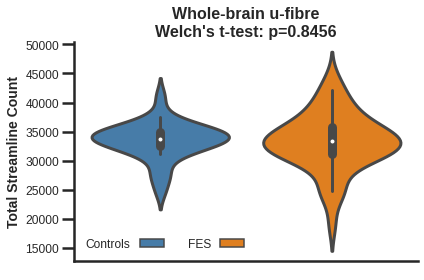

In [11]:
# Total streamline count - HC v P
%matplotlib inline

plot_df = topsy_count_df[topsy_count_df["Cluster"] == "Total"]

# gridkw = dict(height_ratios=[.6, .4], hspace=0.1)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

sns.violinplot(
    x="Group", y="Count", data=plot_df, hue="Group", dodge=False, inner="box", ax=ax
)

# Plot settings
sns.despine(ax=ax, right=True, top=True)
ax.set_xticks([])
ax.set_xticklabels([])
ax.get_legend().remove()
ax.set_xlabel("")
ax.set_ylabel("Total Streamline Count")

# Headings
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[:2],
    ["Controls", "FES"],
    frameon=False,
    markerfirst=False,
    ncol=2,
    loc="lower left",
)

# Non parametric t test
stat, p = scipy.stats.ttest_ind(
    plot_df[plot_df["Group"] == 0]["Count"].tolist(),
    plot_df[plot_df["Group"] == 1]["Count"].tolist(),
    equal_var=False,
)
ax.set_title(f"Whole-brain u-fibre\nWelch's t-test: p={p:.4f}")

fig.tight_layout()
filename = "{0}/1_TotalStreamlineCount_HCvFES.svg".format(figure_dir)
# plt.savefig(filename, dpi=300, bbox_inches="tight", facecolor="white")
plt.show()
plt.close()

del plot_df

In [12]:
plot_df = topsy_count_df[topsy_count_df["Cluster"] == "Total"]

# Test for normality
print(scipy.stats.shapiro(plot_df[plot_df["Group"] == 0]["Count"].tolist()))
print(scipy.stats.shapiro(plot_df[plot_df["Group"] == 1]["Count"].tolist()))

# Tests if two samples have equal variances
stat, p = scipy.stats.bartlett(
    plot_df[plot_df["Group"] == 0]["Count"].tolist(),
    plot_df[plot_df["Group"] == 1]["Count"].tolist(),
)

del plot_df

print(stat, p)

(0.9268788695335388, 0.05796829238533974)
(0.9689627289772034, 0.27800920605659485)
5.703156961602046 0.016934426996006086


In [133]:
# Find number of subjects meeting threshold criteria
threshold = 0.7

hc_thresh = round(
    len(np.unique(topsy_count_df[topsy_count_df["Group"] == 0]["Subject"])) * threshold
)
fes_thresh = round(
    len(np.unique(topsy_count_df[topsy_count_df["Group"] == 1]["Subject"])) * threshold
)

print(
    f"No. of HC and FES to survive thresholding at {threshold * 100:.0f}%: {hc_thresh}, {fes_thresh}"
)

No. of HC and FES to survive thresholding at 70%: 19, 31


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 611.52it/s]


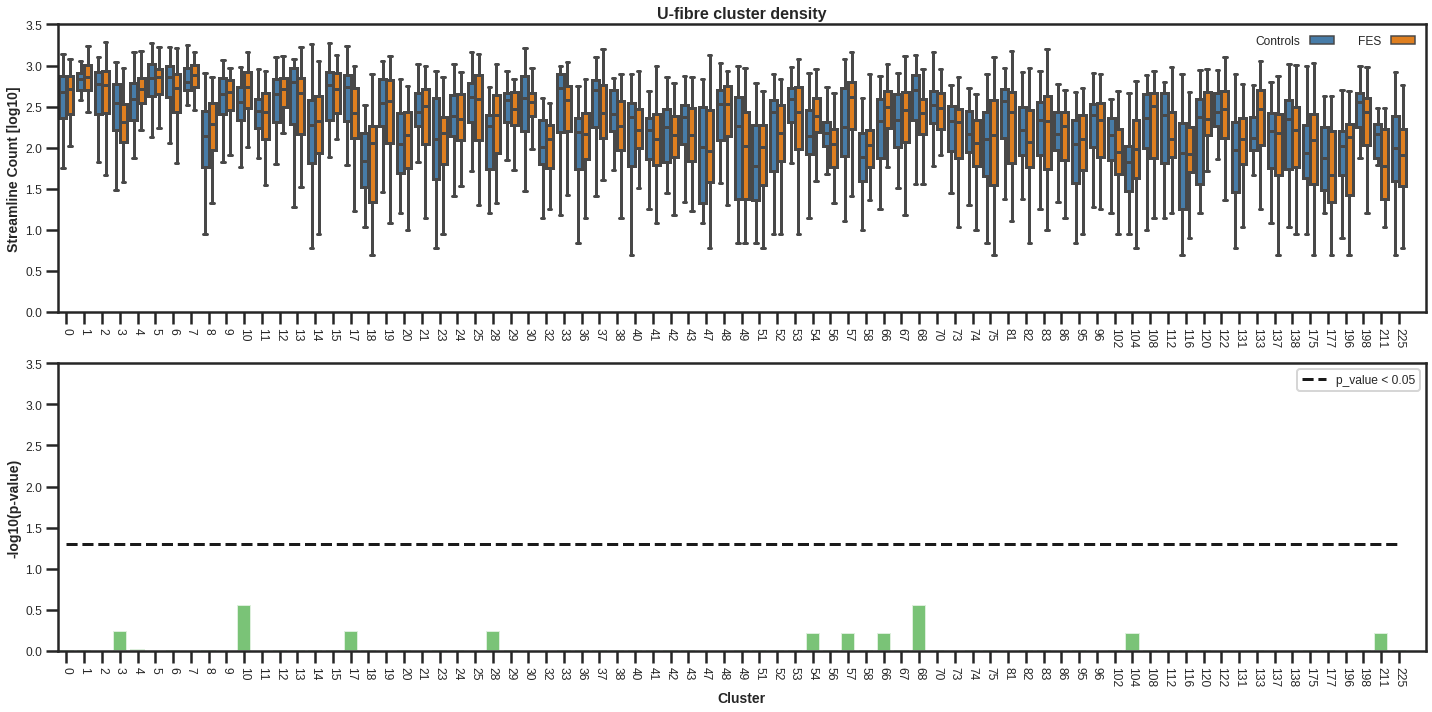

In [14]:
# Bundle specific streamline count
%matplotlib inline

# Drop rows/columns of non analyzed subjects and clusters
plot_df = topsy_count_df.drop(
    topsy_count_df[topsy_count_df["Cluster"] == "Total"].index
)
plot_df = plot_df.drop(plot_df[plot_df["Count"] < 5].index)
for cluster in np.unique(plot_df["Cluster"].values):
    if (
        len(plot_df[(plot_df["Cluster"] == cluster) & (plot_df["Group"] == 0)].index)
        < hc_thresh
    ):
        plot_df = plot_df[plot_df["Cluster"] != cluster]
        continue

    if (
        len(plot_df[(plot_df["Cluster"] == cluster) & (plot_df["Group"] == 1)].index)
        < fes_thresh
    ):
        plot_df = plot_df[plot_df["Cluster"] != cluster]
        continue

plot_df["Count (log10)"] = np.log10(plot_df["Count"])
plot_df = plot_df.replace(-np.inf, 0)

fig, ax = plt.subplots(2, 1, figsize=(20, 10))

# Density plot
sns.boxplot(
    x="Cluster",
    y="Count (log10)",
    data=plot_df,
    hue="Group",
    ax=ax[0],
    fliersize=0,
    dodge=True,
)
# Settings
ax[0].set_ylim([0, 3.5])
ax[0].set_ylabel("Streamline Count [log10]")
ax[0].tick_params("x", labelrotation=-90)
ax[0].set_xlim([-0.5, len(np.unique(plot_df["Cluster"])) + 0.5])
ax[0].set_xlabel("")
ax[0].set_title("U-fibre cluster density")
ax[0].get_legend().remove()
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(
    handles[:2],
    ["Controls", "FES"],
    frameon=False,
    markerfirst=False,
    ncol=2,
    loc="upper right",
)

# Comute differences between groups
p_list = np.array([])
for cidx in tqdm(np.unique(plot_df["Cluster"].values)):
    stat, p = scipy.stats.ttest_ind(
        plot_df[(plot_df["Group"] == 0) & (plot_df["Cluster"] == cidx)][
            "Count"
        ].tolist(),
        plot_df[(plot_df["Group"] == 1) & (plot_df["Cluster"] == cidx)][
            "Count"
        ].tolist(),
        equal_var=False,
    )
    p_list = np.append(p_list, p)

nan_idx = np.argwhere(np.isnan(p_list))
p_list = np.delete(p_list, nan_idx)
_, cor_plist, _, _ = smstats.multipletests(p_list, method="fdr_bh")
for idx in nan_idx:
    cor_plist = np.insert(cor_plist, idx, np.nan)

# p-value plot
# Shows p-value for significance following FDR correction (BH)
(l1,) = plt.plot(
    np.arange(len(np.unique(plot_df["Cluster"].values))),
    np.ones((len(np.unique(plot_df["Cluster"].values)), 1)) * (-np.log10(0.05)),
    "k--",
    label="p_value < 0.05",
    axes=ax[1],
)

plt.bar(
    np.arange(len(np.unique(plot_df["Cluster"].values))),
    -np.log10(cor_plist),
    color=cb_color_cycle[2],
    width=0.8,
    axes=ax[1],
    alpha=0.75,
)
# Settings
ax[1].set_ylabel("-log10(p-value)")
ax[1].set_ylim([0, 3.5])
ax[1].set_xlabel("Cluster")
ax[1].set_xticks(np.arange(len(np.unique(plot_df["Cluster"].values))))
ax[1].set_xticklabels(np.unique(plot_df["Cluster"].values))
ax[1].set_xlim([-0.5, len(np.unique(plot_df["Cluster"].values)) + 0.5])
ax[1].tick_params("x", labelrotation=-90)
ax[1].legend(handles=[l1], loc="upper right")

fig.tight_layout()
filename = "{0}/2_BundleStreamlineCount_HCvFES.svg".format(figure_dir)
# plt.savefig(filename, dpi=300, bbox_inches="tight", facecolor="white")
plt.show()
# plt.close()

del plot_df

##### Streamline count manuscript figure

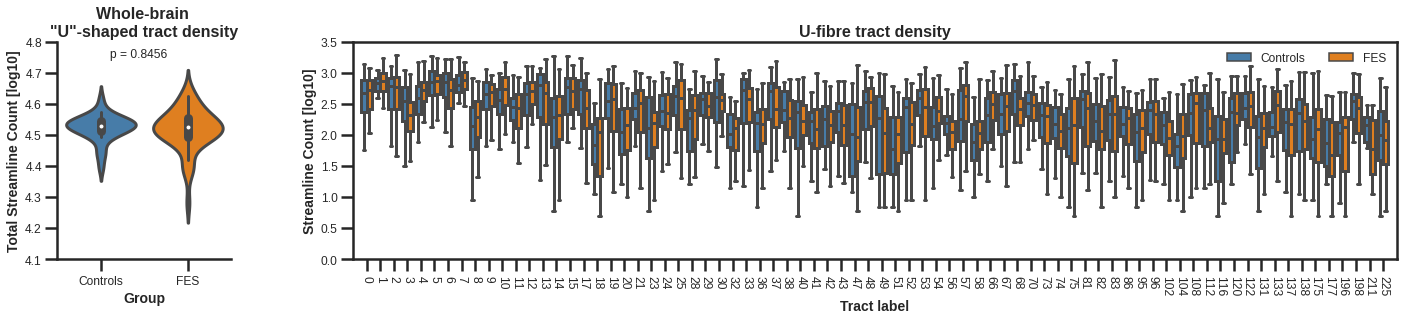

In [15]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(24, 4))

# Main confiugration
gs_parent = gridspec.GridSpec(1, 2, figure=fig, width_ratios=[1, 6])

# Whole-brain cofdffunt (ax1)
gs_left = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_parent[0])
ax1 = fig.add_subplot(gs_left[0])

plot_df = topsy_count_df[topsy_count_df["Cluster"] == "Total"]
plot_df["Count (log)"] = np.log10(plot_df["Count"])

sns.violinplot(
    x="Group",
    y="Count (log)",
    data=plot_df,
    hue="Group",
    dodge=False,
    inner="box",
    ax=ax1,
)
# Non parametric t test
stat, p = scipy.stats.ttest_ind(
    plot_df[plot_df["Group"] == 0]["Count"].tolist(),
    plot_df[plot_df["Group"] == 1]["Count"].tolist(),
    equal_var=False,
)

# Plot settings
sns.despine(ax=ax1, right=True, top=True)
ax1.set_xticklabels(["Controls", "FES"])
ax1.get_legend().remove()
ax1.set_ylim([4.1, 4.8])
ax1.set_ylabel("Total Streamline Count [log10]")
ax1.set_title('Whole-brain \n"U"-shaped tract density')
ax1.text(0.1, 4.75, f"p = {p:.4f}", fontsize=12)


# Individual tract density (ax1)
gs_right = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_parent[1])
ax2 = fig.add_subplot(gs_right[0])
# ax3 = fig.add_subplot(gs_right[1])

# Drop rows/columns of non analyzed subjects and clusters
plot_df = topsy_count_df.drop(
    topsy_count_df[topsy_count_df["Cluster"] == "Total"].index
)
plot_df = plot_df.drop(plot_df[plot_df["Count"] < 5].index)
for cluster in np.unique(plot_df["Cluster"].values):
    if (
        len(plot_df[(plot_df["Cluster"] == cluster) & (plot_df["Group"] == 0)].index)
        < hc_thresh
    ):
        plot_df = plot_df[plot_df["Cluster"] != cluster]
        continue

    if (
        len(plot_df[(plot_df["Cluster"] == cluster) & (plot_df["Group"] == 1)].index)
        < fes_thresh
    ):
        plot_df = plot_df[plot_df["Cluster"] != cluster]
        continue

plot_df["Count (log10)"] = np.log10(plot_df["Count"])
plot_df = plot_df.replace(-np.inf, 0)

# Density plot
sns.boxplot(
    x="Cluster",
    y="Count (log10)",
    data=plot_df,
    hue="Group",
    ax=ax2,
    fliersize=0,
    dodge=True,
)
# Settings
ax2.set_ylim([0, 3.5])
ax2.set_ylabel("Streamline Count [log10]")
ax2.set_xlim([-1, len(np.unique(plot_df["Cluster"]))])
ax2.set_xlabel("Tract label")
ax2.tick_params("x", labelrotation=-90)
ax2.set_title("U-fibre tract density")
ax2.get_legend().remove()
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles[:2], ["Controls", "FES"], frameon=False, ncol=2, loc="upper right")

# # Comute differences between groups
# p_list = np.array([])
# for cidx in tqdm(np.unique(plot_df["Cluster"].values)):
#     stat, p = scipy.stats.ttest_ind(
#         plot_df[(plot_df["Group"] == 0) & (plot_df["Cluster"] == cidx)][
#             "Count"
#         ].tolist(),
#         plot_df[(plot_df["Group"] == 1) & (plot_df["Cluster"] == cidx)][
#             "Count"
#         ].tolist(),
#         equal_var=False,
#     )
#     p_list = np.append(p_list, p)

# nan_idx = np.argwhere(np.isnan(p_list))
# p_list = np.delete(p_list, nan_idx)
# _, cor_plist, _, _ = smmulti.multipletests(p_list, method="fdr_bh")
# for idx in nan_idx:
#     cor_plist = np.insert(cor_plist, idx, np.nan)

# # p-value plot
# # Shows p-value for significance following FDR correction (BH)
# (l1,) = plt.plot(
#     np.arange(len(np.unique(plot_df["Cluster"].values))),
#     np.ones((len(np.unique(plot_df["Cluster"].values)), 1)) * (-np.log10(0.05)),
#     "k--",
#     label="$p_{fdr}$ < 0.05",
#     axes=ax3,
# )

# plt.bar(
#     np.arange(len(np.unique(plot_df["Cluster"].values))),
#     -np.log10(cor_plist),
#     color=cb_color_cycle[2],
#     width=0.8,
#     axes=ax3,
#     alpha=0.75,
# )
# # Settings
# ax3.set_ylabel("-log10(p-value)")
# ax3.set_ylim([0, 3.5])
# ax3.set_xlabel("Tract Label")
# ax3.set_xticks(np.arange(len(np.unique(plot_df["Cluster"].values))))
# ax3.set_xticklabels(np.unique(plot_df["Cluster"].values))
# ax3.set_xlim([-1, len(np.unique(plot_df["Cluster"].values))])
# ax3.tick_params("x", labelrotation=-90)
# ax3.legend(handles=[l1], loc="upper left", frameon=False)

del plot_df
filename = f"{figure_dir}/tract_density.svg"
# plt.savefig(filename, dpi=300, bbox_inches="tight", facecolor="white")

plt.show()
# plt.close()

In [16]:
plt.close()

#### Cluster lobular assignment 

In [24]:
# Assign clusters to lobe & determine if missing or present
cluster_df = topsy_count_df.copy()
cluster_df = cluster_df[cluster_df["Cluster"] != "Total"]
cluster_df["Lobe"] = np.nan
cluster_df["Present"] = 0

for cluster in range(249):
    sl_count = 0
    for cluster_file in glob.iglob(
        # f"{template_dir}/tractography/edge/tractography_*/*Cluster{cluster}.vtk"
        f"/localscratch/tkai/tractography/*Cluster{cluster}_*.vtk"
    ):
        bundle_vtk = tractio.readVTK(cluster_file)

        if bundle_vtk.GetNumberOfLines() > sl_count:
            sl_count = bundle_vtk.GetNumberOfLines()
            node = cluster_file.split("/")[-1].split("from-")[-1].strip(".vtk")

    for row in tqdm(cluster_df.iterrows()):
        if cluster_df.loc[row[0], "Cluster"] == cluster:
            cluster_df.loc[row[0], "Lobe"] = node
            cluster_df.loc[row[0], "Present"] = (
                0 if cluster_df.loc[row[0], "Count"] == 0 else 1
            )
            
    try:
        del bundle_vtk
    except:
        continue 
        
    clear_output(wait=True)
cluster_df.dropna(inplace=True)

17679it [00:01, 16942.36it/s]


In [25]:
# Check to see how many clusters were dropped in each lobe (relative to retained)
# Drop rows/columns of non analyzed subjects and clusters
plot_df = topsy_count_df.drop(
    topsy_count_df[topsy_count_df["Cluster"] == "Total"].index
)
plot_df = plot_df.drop(plot_df[plot_df["Count"] < 5].index)
for cluster in np.unique(plot_df["Cluster"].values):
    if (
        len(plot_df[(plot_df["Cluster"] == cluster) & (plot_df["Group"] == 0)].index)
        < hc_thresh
    ):
        plot_df = plot_df[plot_df["Cluster"] != cluster]
        continue

    if (
        len(plot_df[(plot_df["Cluster"] == cluster) & (plot_df["Group"] == 1)].index)
        < fes_thresh
    ):
        plot_df = plot_df[plot_df["Cluster"] != cluster]
        continue

In [26]:
for node_label in itertools.combinations_with_replacement(range(1, 11), 2):
    node = f"{node_label[0]}-{node_label[1]}"

    total_lobe = set(cluster_df[(cluster_df["Lobe"] == node)]["Cluster"])
    thresh_lobe = set(plot_df["Cluster"].tolist()) & set(total_lobe)

    try:
        print(
            f"Remaining clusters for node {node} surviving threshold: {len(thresh_lobe & total_lobe)} ({len(thresh_lobe & total_lobe) / len(total_lobe) * 100:.2f}%)"
        )
    except:
        print(f"No clusters found for node {node}")

Remaining clusters for node 1-1 surviving threshold: 21 (38.18%)
Remaining clusters for node 1-2 surviving threshold: 1 (14.29%)
Remaining clusters for node 1-3 surviving threshold: 1 (50.00%)
No clusters found for node 1-4
Remaining clusters for node 1-5 surviving threshold: 0 (0.00%)
No clusters found for node 1-6
No clusters found for node 1-7
No clusters found for node 1-8
No clusters found for node 1-9
No clusters found for node 1-10
Remaining clusters for node 2-2 surviving threshold: 9 (27.27%)
Remaining clusters for node 2-3 surviving threshold: 1 (100.00%)
Remaining clusters for node 2-4 surviving threshold: 0 (0.00%)
No clusters found for node 2-5
No clusters found for node 2-6
No clusters found for node 2-7
No clusters found for node 2-8
No clusters found for node 2-9
No clusters found for node 2-10
Remaining clusters for node 3-3 surviving threshold: 2 (16.67%)
Remaining clusters for node 3-4 surviving threshold: 0 (0.00%)
No clusters found for node 3-5
No clusters found fo

#### Along tract scalars

##### Compute template centroids in each subject space

In [90]:
# Set up dict for centroids
bundle_data = dict()
bundle_data["Subject"] = []
bundle_data["Cluster"] = []
bundle_data["Centroid"] = []

for subject in tqdm(np.unique(topsy_count_df["Subject"].tolist())):
    print("Grabbing template tractography in subject space...")
    os.system(
        f"unzip -qo {derivatives_dir}/neurobeer_1.2.1/work/sub-HCPUR100_space-{subject}.zip -d {derivatives_dir}/neurobeer_1.2.1/work"
    )

    for cluster in range(249):
        subject, cluster, centroid = compute_template_centroid(
            subject, derivatives_dir, cluster
        )

        bundle_data["Subject"].append(subject)
        bundle_data["Cluster"].append(cluster)
        bundle_data["Centroid"].extend(centroid)

    print("Cleaning up directory...")
    os.system(f"rm {derivatives_dir}/neurobeer_1.2.1/work/vtk/*.vtk")
    clear_output(wait=True)

# Convert to dataframe
template_centroids_df = pd.DataFrame(bundle_data)

handle_session(save=True)
handle_df(template_centroids_df, "template_centroids_df", save=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [29:11<00:00, 24.67s/it]


Saving notebook session
Saving dataframe


##### FA

In [31]:
for cluster in tqdm(np.arange(249), position=0):
    bundle_fa_df = pd.DataFrame(
        columns=["Subject", "Streamline", "Streamline Sample", "Scalar", "Group"]
    )

    subject_fa_dfs = Parallel(n_jobs=n_proc, backend="multiprocessing", verbose=1)(
        delayed(extract_bundle_scalar)(
            subject,
            derivatives_dir,
            cluster,
            template_centroids_df,
            "FA",
            topsy_template_df=demo_df,
        )
        for subject in tqdm(np.unique(topsy_count_df["Subject"].tolist()), position=1)
    )

    try:
        bundle_fa_df = bundle_fa_df.append(pd.concat(subject_fa_dfs))
        handle_df(bundle_fa_df, f"cluster{cluster}_fa_df", save=True)

        del subject_fa_dfs
    except:
        continue

    # Jupyter command to clear output cell
    clear_output(wait=True)

# Zip all scalar dataframes into single zip file
print("Zipping up subject csvs...")
os.system("zip -Z store -rum dataframes/fa.zip dataframes/cluster*_fa_*.csv")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [50:23<00:00, 12.14s/it]


Zipping up subject csvs...
updating: dataframes/cluster0_fa_df.csv (stored 0%)
updating: dataframes/cluster100_fa_df.csv (stored 0%)
updating: dataframes/cluster101_fa_df.csv (stored 0%)
updating: dataframes/cluster102_fa_df.csv (stored 0%)
updating: dataframes/cluster103_fa_df.csv (stored 0%)
updating: dataframes/cluster104_fa_df.csv (stored 0%)
updating: dataframes/cluster105_fa_df.csv (stored 0%)
updating: dataframes/cluster106_fa_df.csv (stored 0%)
updating: dataframes/cluster107_fa_df.csv (stored 0%)
updating: dataframes/cluster108_fa_df.csv (stored 0%)
updating: dataframes/cluster109_fa_df.csv (stored 0%)
updating: dataframes/cluster10_fa_df.csv (stored 0%)
updating: dataframes/cluster110_fa_df.csv (stored 0%)
updating: dataframes/cluster111_fa_df.csv (stored 0%)
updating: dataframes/cluster112_fa_df.csv (stored 0%)
updating: dataframes/cluster113_fa_df.csv (stored 0%)
updating: dataframes/cluster114_fa_df.csv (stored 0%)
updating: dataframes/cluster115_fa_df.csv (stored 0%)
upda

0

In [32]:
print("Unzipping subject csvs...")
os.system("unzip -u dataframes/fa.zip -d .")

# Get subject means
subject_mean_df = dict()
subject_mean_df["Subject"] = []
subject_mean_df["Group"] = []
subject_mean_df["Cluster"] = []
for i in np.arange(20):
    subject_mean_df[f"Sample {i}"] = []

sl_min = 5
for cluster in tqdm(np.arange(249), position=0):
    if (
        len(
            topsy_count_df[
                (topsy_count_df["Group"] == 0)
                & (topsy_count_df["Cluster"] == cluster)
                & (topsy_count_df["Count"] >= sl_min)
            ]
        )
        >= hc_thresh
    ) and (
        len(
            topsy_count_df[
                (topsy_count_df["Group"] == 1)
                & (topsy_count_df["Cluster"] == cluster)
                & (topsy_count_df["Count"] >= sl_min)
            ]
        )
        >= fes_thresh
    ):

        bundle_fa_df = handle_df(None, f"cluster{cluster}_fa_df")

        for i in np.arange(20):
            df = (
                bundle_fa_df[bundle_fa_df["Streamline Sample"] == i]
                .groupby(["Subject"])
                .mean()
            )
            subject_mean_df[f"Sample {i}"].extend(df["Scalar"].tolist())

        subject_mean_df["Subject"].extend(df.index.tolist())
        subject_mean_df["Group"].extend(demo_df[demo_df["Subject"].isin(bundle_fa_df["Subject"].unique())]["Group"].tolist())
        subject_mean_df["Cluster"].extend([cluster] * len(df.index.tolist()))

    clear_output(wait=True)

subject_fa_df = pd.DataFrame(subject_mean_df)
subject_fa_df['Group'] = subject_fa_df['Group'].map({"HC": 0, "P": 1})

print("Cleaning up directory...")
os.system("rm dataframes/cluster*_fa_df.csv")

handle_df(subject_fa_df, "subject_fa_df", save=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:47<00:00,  5.27it/s]


Cleaning up directory...
Saving dataframe


In [33]:
# Create a general confounds dataframe
subject_fa_df["Group"] = subject_fa_df["Group"].astype(int)
subject_fa_df = subject_fa_df.dropna()
subject_confounds_df = subject_fa_df.copy()

for i in np.arange(20):
    subject_confounds_df = subject_confounds_df.drop(columns=f"Sample {i}")

for idx in subject_confounds_df.index.tolist():
    subj = subject_confounds_df.loc[idx, "Subject"]
    subject_confounds_df.at[idx, "Age"] = int(
        demo_df[demo_df["Subject"] == subj]["Age"].values[0]
    )
    subject_confounds_df.at[idx, "Sex"] = demo_df[
        demo_df["Subject"] == subj
    ]["Sex"].values[0]

subject_confounds_df = subject_confounds_df.replace("M", int(0))
subject_confounds_df = subject_confounds_df.replace("F", int(1))

handle_df(subject_confounds_df, "subject_confounds_df", save=True)

Saving dataframe


In [37]:
group_df = dict()
group_df["Cluster"] = []
group_df["Scalar"] = []
group_df["Streamline Sample"] = []
group_df["t-stat"] = []
group_df["p-val"] = []
group_df["alphaFWE"] = []

# Correct for confounds
print("Correcting for confounds...")
corrected_samples = unconfound(
    subject_fa_df.drop(columns=["Subject", "Group", "Cluster"]).to_numpy(),
    subject_confounds_df.drop(columns=["Subject", "Cluster"]).to_numpy(),
    group_data=True,
)
for idx, df_idx in enumerate(subject_fa_df.index.tolist()):
    for sample in np.arange(corrected_samples.shape[1]):
        subject_fa_df.at[df_idx, f"Sample {sample}"] = corrected_samples[idx, sample]

# Permutation-based multiple comparison correction
print("Adjusting p-value for multiple comparisons...")
alphaFWE, _, _, _, = AFQ_MultiCompCorrection(
    subject_fa_df.drop(columns=["Group", "Cluster", "Subject"]).to_numpy(),
    y=subject_fa_df["Group"].astype("int").tolist(),
    nperm=10000,
)

# T-test
print("Testing for group differences...")
for cluster in tqdm(np.unique(subject_fa_df["Cluster"].tolist()), position=0):
    df = subject_fa_df[subject_fa_df["Cluster"] == cluster]

    for i in tqdm(np.arange(20)):

        t, p = scipy.stats.ttest_ind(
            df[(df["Group"] == 0)][f"Sample {i}"].values,
            df[(df["Group"] == 1)][f"Sample {i}"].values,
            equal_var=False,
        )

        group_df["Cluster"].append(cluster)
        group_df["t-stat"].append(t)
        group_df["p-val"].append(p)
        group_df["Streamline Sample"].append(i)
        group_df["Scalar"].append("FA")
        group_df["alphaFWE"].append(alphaFWE)

    clear_output(wait=True)

group_fa_df = pd.DataFrame(group_df)
del df 

handle_df(group_fa_df, "group_fa_df", save=True)
handle_session(save=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 76/76 [00:02<00:00, 34.76it/s]


Saving dataframe
Saving notebook session


  0%|                                                                                                                                                                             | 0/71 [1:34:23<?, ?it/s]


In [32]:
group_fa_df = handle_df(None, "group_fa_df", verbose=False)
sig_fa_clusters = np.unique(
    group_fa_df[group_fa_df["p-val"] < group_fa_df["alphaFWE"]]["Cluster"]
)

for cluster in sig_fa_clusters:
    sig_cluster_summary(cluster, topsy_count_df, sl_min=5)

Cluster 9 summary:
Connectivity: L Frontal - L Frontal
No. of controls: 27
Avg. streamline count: 475.4 [(6.0, 1155.0)]
No. of FES: 44
Avg. streamline count: 471.7 [(15.0, 930.0)]

Cluster 37 summary:
Connectivity: L Parietal - L Parietal
No. of controls: 27
Avg. streamline count: 457.3 [(6.0, 1254.0)]
No. of FES: 42
Avg. streamline count: 413.0 [(6.0, 1567.0)]



Grabbing csvs of significant clusters...
Cleaning up directory...
Grabbing csvs of significant clusters...
Cleaning up directory...


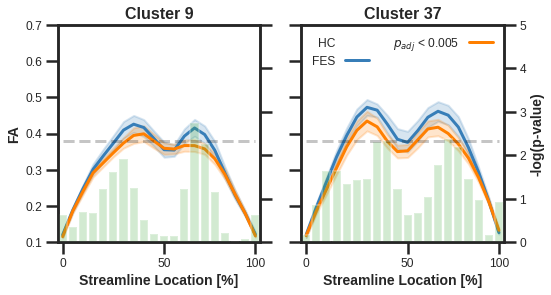

In [69]:
fig, ax = plt.subplots(1, len(sig_fa_clusters), figsize=(len(sig_fa_clusters) * 4, 4))

group_fa_df = handle_df(None, "group_fa_df", verbose=False)
for ix, cluster in enumerate(sig_fa_clusters):
    print("Grabbing csvs of significant clusters...")
    os.system(
        f"unzip -qq -u dataframes/fa.zip dataframes/cluster{cluster}_fa_df.csv -d ."
    )

    bundle_fa_df = handle_df(None, f"cluster{cluster}_fa_df", verbose=False)
    plot_along_tract(
        bundle_fa_df,
        group_fa_df,
        cluster,
        ax,
        ix % 4,
        ylabel="FA",
        ylim=[0.1, 0.7],
        pval=group_fa_df[group_fa_df["Cluster"] == cluster]["alphaFWE"].values[0],
    )

    print("Cleaning up directory...")
    os.system(f"rm dataframes/*{cluster}_fa_df.csv")

# fig.savefig("/home/ROBARTS/tkai/Desktop/FA.png", dpi=300, bbox_inches="tight")

##### RD

In [71]:
for cluster in tqdm(np.arange(249), position=0):
    bundle_rd_df = pd.DataFrame(
        columns=["Subject", "Streamline", "Streamline Sample", "Scalar", "Group"]
    )

    subject_rd_dfs = Parallel(n_jobs=n_proc, backend="multiprocessing", verbose=1)(
        delayed(extract_bundle_scalar)(
            subject,
            derivatives_dir,
            cluster,
            template_centroids_df,
            "RD",
            topsy_template_df=demo_df,
        )
        for subject in tqdm(np.unique(topsy_count_df["Subject"].tolist()), position=1)
    )

    try:
        bundle_rd_df = bundle_rd_df.append(pd.concat(subject_rd_dfs))
        handle_df(bundle_rd_df, f"cluster{cluster}_rd_df", save=True)

        del subject_rd_dfs
    except:
        continue

    # Jupyter command to clear output cell
    clear_output(wait=True)

# Zip all scalar dataframes into single zip file
print("Zipping up csvs...")
os.system("zip -Z store -rum dataframes/rd.zip dataframes/cluster*_rd_*.csv")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [50:26<00:00, 12.15s/it]


Zipping up csvs...
	zip warning: dataframes/rd.zip not found or empty
  adding: dataframes/cluster0_rd_df.csv (stored 0%)
  adding: dataframes/cluster100_rd_df.csv (stored 0%)
  adding: dataframes/cluster101_rd_df.csv (stored 0%)
  adding: dataframes/cluster102_rd_df.csv (stored 0%)
  adding: dataframes/cluster103_rd_df.csv (stored 0%)
  adding: dataframes/cluster104_rd_df.csv (stored 0%)
  adding: dataframes/cluster105_rd_df.csv (stored 0%)
  adding: dataframes/cluster106_rd_df.csv (stored 0%)
  adding: dataframes/cluster107_rd_df.csv (stored 0%)
  adding: dataframes/cluster108_rd_df.csv (stored 0%)
  adding: dataframes/cluster109_rd_df.csv (stored 0%)
  adding: dataframes/cluster10_rd_df.csv (stored 0%)
  adding: dataframes/cluster110_rd_df.csv (stored 0%)
  adding: dataframes/cluster111_rd_df.csv (stored 0%)
  adding: dataframes/cluster112_rd_df.csv (stored 0%)
  adding: dataframes/cluster113_rd_df.csv (stored 0%)
  adding: dataframes/cluster114_rd_df.csv (stored 0%)
  adding: dataf

0

In [72]:
print("Unzipping RD csvs...")
os.system("unzip -u dataframes/rd.zip -d .")

# Get subject means
subject_mean_df = dict()
subject_mean_df["Subject"] = []
subject_mean_df["Group"] = []
subject_mean_df["Cluster"] = []
for i in np.arange(20):
    subject_mean_df[f"Sample {i}"] = []

sl_min = 5
for cluster in tqdm(np.arange(249), position=0):
    if (
        len(
            topsy_count_df[
                (topsy_count_df["Group"] == 0)
                & (topsy_count_df["Cluster"] == cluster)
                & (topsy_count_df["Count"] >= sl_min)
            ]
        )
        >= hc_thresh
    ) and (
        len(
            topsy_count_df[
                (topsy_count_df["Group"] == 1)
                & (topsy_count_df["Cluster"] == cluster)
                & (topsy_count_df["Count"] >= sl_min)
            ]
        )
        >= fes_thresh
    ):

        bundle_rd_df = handle_df(None, f"cluster{cluster}_rd_df")

        for i in np.arange(20):
            df = (
                bundle_rd_df[bundle_rd_df["Streamline Sample"] == i]
                .groupby(["Subject"])
                .mean()
            )
            subject_mean_df[f"Sample {i}"].extend(df["Scalar"].tolist())

        subject_mean_df["Subject"].extend(df.index.tolist())
        subject_mean_df["Group"].extend(demo_df[demo_df["Subject"].isin(bundle_rd_df["Subject"].unique())]["Group"].tolist())
        subject_mean_df["Cluster"].extend([cluster] * len(df.index.tolist()))

    clear_output(wait=True)

subject_rd_df = pd.DataFrame(subject_mean_df)
subject_rd_df['Group'] = subject_rd_df['Group'].map({"HC": 0, "P": 1})

print("Cleaning up directory...")
os.system("rm dataframes/cluster*_rd_df.csv")

handle_df(subject_rd_df, "subject_rd_df", save=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:58<00:00,  4.28it/s]


Cleaning up directory...
Saving dataframe


In [73]:
group_df = dict()
group_df["Cluster"] = []
group_df["Scalar"] = []
group_df["Streamline Sample"] = []
group_df["t-stat"] = []
group_df["p-val"] = []
group_df["alphaFWE"] = []

# Correct for confounds
print("Correcting for confounds...")
corrected_samples = unconfound(
    subject_rd_df.drop(columns=["Subject", "Group", "Cluster"]).to_numpy(),
    subject_confounds_df.drop(columns=["Subject", "Cluster"]).to_numpy(),
    group_data=True,
)
for idx, df_idx in enumerate(subject_rd_df.index.tolist()):
    for sample in np.arange(corrected_samples.shape[1]):
        subject_rd_df.at[df_idx, f"Sample {sample}"] = corrected_samples[idx, sample]

# Permutation-based multiple comparison correction
print("Adjusting p-value for multiple comparisons...")
alphaFWE, _, _, _, = AFQ_MultiCompCorrection(
    subject_rd_df.drop(columns=["Group", "Cluster", "Subject"]).to_numpy(),
    y=subject_rd_df["Group"].astype("int").tolist(),
    nperm=10000,
)

# T-test
print("Testing for group differences...")
for cluster in tqdm(np.unique(subject_rd_df["Cluster"].tolist()), position=0):
    df = subject_rd_df[subject_rd_df["Cluster"] == cluster]

    for i in tqdm(np.arange(20)):

        t, p = scipy.stats.ttest_ind(
            df[(df["Group"] == 0)][f"Sample {i}"].values,
            df[(df["Group"] == 1)][f"Sample {i}"].values,
            equal_var=False,
        )

        group_df["Cluster"].append(cluster)
        group_df["t-stat"].append(t)
        group_df["p-val"].append(p)
        group_df["Streamline Sample"].append(i)
        group_df["Scalar"].append("RD")
        group_df["alphaFWE"].append(alphaFWE)

    clear_output(wait=True)

group_rd_df = pd.DataFrame(group_df)

handle_df(group_rd_df, "group_rd_df", save=True)
handle_session(save=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 76/76 [00:02<00:00, 36.50it/s]


Saving dataframe
Saving notebook session


##### AD

In [75]:
for cluster in tqdm(np.arange(249), position=0):
    bundle_ad_df = pd.DataFrame(
        columns=["Subject", "Streamline", "Streamline Sample", "Scalar", "Group"]
    )

    subject_ad_dfs = Parallel(n_jobs=n_proc, backend="multiprocessing", verbose=1)(
        delayed(extract_bundle_scalar)(
            subject,
            derivatives_dir,
            cluster,
            template_centroids_df,
            "AD",
            topsy_template_df=demo_df,
        )
        for subject in tqdm(np.unique(topsy_count_df["Subject"].tolist()), position=1)
    )

    try:
        bundle_ad_df = bundle_ad_df.append(pd.concat(subject_ad_dfs))
        handle_df(bundle_ad_df, f"cluster{cluster}_ad_df", save=True)

        del subject_ad_dfs
    except:
        continue

    # Jupyter command to clear output cell
    clear_output(wait=True)

# Zip all scalar dataframes into single zip file
print("Zipping up csvs...")
os.system("zip -Z store -rum dataframes/ad.zip dataframes/cluster*_ad_*.csv")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [48:33<00:00, 11.70s/it]


Zipping up csvs...
	zip warning: dataframes/ad.zip not found or empty
  adding: dataframes/cluster0_ad_df.csv (stored 0%)
  adding: dataframes/cluster100_ad_df.csv (stored 0%)
  adding: dataframes/cluster101_ad_df.csv (stored 0%)
  adding: dataframes/cluster102_ad_df.csv (stored 0%)
  adding: dataframes/cluster103_ad_df.csv (stored 0%)
  adding: dataframes/cluster104_ad_df.csv (stored 0%)
  adding: dataframes/cluster105_ad_df.csv (stored 0%)
  adding: dataframes/cluster106_ad_df.csv (stored 0%)
  adding: dataframes/cluster107_ad_df.csv (stored 0%)
  adding: dataframes/cluster108_ad_df.csv (stored 0%)
  adding: dataframes/cluster109_ad_df.csv (stored 0%)
  adding: dataframes/cluster10_ad_df.csv (stored 0%)
  adding: dataframes/cluster110_ad_df.csv (stored 0%)
  adding: dataframes/cluster111_ad_df.csv (stored 0%)
  adding: dataframes/cluster112_ad_df.csv (stored 0%)
  adding: dataframes/cluster113_ad_df.csv (stored 0%)
  adding: dataframes/cluster114_ad_df.csv (stored 0%)
  adding: dataf

0

In [78]:
print("Unzipping AD csvs...")
os.system("unzip -u dataframes/ad.zip -d .")

# Get subject means
subject_mean_df = dict()
subject_mean_df["Subject"] = []
subject_mean_df["Group"] = []
subject_mean_df["Cluster"] = []
for i in np.arange(20):
    subject_mean_df[f"Sample {i}"] = []

sl_min = 5
for cluster in tqdm(np.arange(249), position=0):
    if (
        len(
            topsy_count_df[
                (topsy_count_df["Group"] == 0)
                & (topsy_count_df["Cluster"] == cluster)
                & (topsy_count_df["Count"] >= sl_min)
            ]
        )
        >= hc_thresh
    ) and (
        len(
            topsy_count_df[
                (topsy_count_df["Group"] == 1)
                & (topsy_count_df["Cluster"] == cluster)
                & (topsy_count_df["Count"] >= sl_min)
            ]
        )
        >= fes_thresh
    ):

        bundle_ad_df = handle_df(None, f"cluster{cluster}_ad_df")

        for i in np.arange(20):
            df = (
                bundle_ad_df[bundle_ad_df["Streamline Sample"] == i]
                .groupby(["Subject"])
                .mean()
            )
            subject_mean_df[f"Sample {i}"].extend(df["Scalar"].tolist())

        subject_mean_df["Subject"].extend(df.index.tolist())
        subject_mean_df["Group"].extend(demo_df[demo_df["Subject"].isin(bundle_ad_df["Subject"].unique())]["Group"].tolist())
        subject_mean_df["Cluster"].extend([cluster] * len(df.index.tolist()))

    clear_output(wait=True)

subject_ad_df = pd.DataFrame(subject_mean_df)
subject_ad_df['Group'] = subject_ad_df['Group'].map({"HC": 0, "P": 1})

print("Cleaning up directory...")
os.system("rm dataframes/cluster*_ad_df.csv")

handle_df(subject_ad_df, "subject_ad_df", save=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:26<00:00,  9.40it/s]


Cleaning up directory...
Saving dataframe


In [79]:
group_df = dict()
group_df["Cluster"] = []
group_df["Scalar"] = []
group_df["Streamline Sample"] = []
group_df["t-stat"] = []
group_df["p-val"] = []
group_df["alphaFWE"] = []

# Correct for confounds
print("Correcting for confounds...")
corrected_samples = unconfound(
    subject_ad_df.drop(columns=["Subject", "Group", "Cluster"]).to_numpy(),
    subject_confounds_df.drop(columns=["Subject", "Cluster"]).to_numpy(),
    group_data=True,
)
for idx, df_idx in enumerate(subject_ad_df.index.tolist()):
    for sample in np.arange(corrected_samples.shape[1]):
        subject_ad_df.at[df_idx, f"Sample {sample}"] = corrected_samples[idx, sample]

# Permutation-based multiple comparison correction
print("Adjusting p-value for multiple comparisons...")
alphaFWE, _, _, _, = AFQ_MultiCompCorrection(
    subject_ad_df.drop(columns=["Group", "Cluster", "Subject"]).to_numpy(),
    y=subject_ad_df["Group"].astype("int").tolist(),
    nperm=10000,
)

# T-test
print("Testing for group differences...")
for cluster in tqdm(np.unique(subject_ad_df["Cluster"].tolist()), position=0):
    df = subject_ad_df[subject_ad_df["Cluster"] == cluster]

    for i in tqdm(np.arange(20)):

        t, p = scipy.stats.ttest_ind(
            df[(df["Group"] == 0)][f"Sample {i}"].values,
            df[(df["Group"] == 1)][f"Sample {i}"].values,
            equal_var=False,
        )

        group_df["Cluster"].append(cluster)
        group_df["t-stat"].append(t)
        group_df["p-val"].append(p)
        group_df["Streamline Sample"].append(i)
        group_df["Scalar"].append("AD")
        group_df["alphaFWE"].append(alphaFWE)

    clear_output(wait=True)

group_ad_df = pd.DataFrame(group_df)

handle_df(group_ad_df, "group_ad_df", save=True)
handle_session(save=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 76/76 [00:02<00:00, 35.55it/s]


Saving dataframe
Saving notebook session


 32%|████████████████████████████████████████████████████▏                                                                                                            | 23/71 [1:31:31<3:11:00, 238.75s/it]


##### DTI Manuscript Figure

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:12<00:00,  6.01s/it]


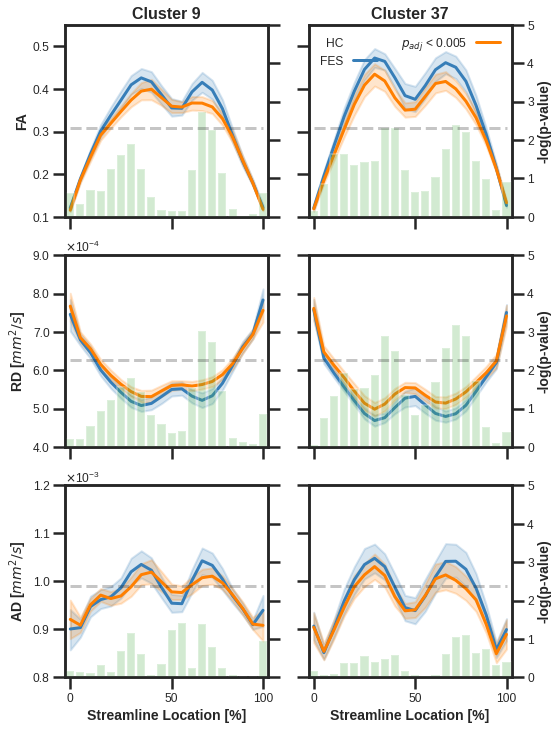

In [94]:
fig, axes = plt.subplots(
    3, len(sig_fa_clusters), figsize=(len(sig_fa_clusters) * 4, 12)
)

group_fa_df = handle_df(None, "group_fa_df", verbose=False)
group_rd_df = handle_df(None, "group_rd_df", verbose=False)
group_ad_df = handle_df(None, "group_ad_df", verbose=False)

for ix, cluster in enumerate(tqdm(sig_fa_clusters)):
    print("Grabbing csvs of significant clusters...")
    os.system(
        f"unzip -qq -u dataframes/fa.zip dataframes/cluster{cluster}_fa_df.csv -d ."
    )
    os.system(
        f"unzip -qq -u dataframes/rd.zip dataframes/cluster{cluster}_rd_df.csv -d ."
    )
    os.system(
        f"unzip -qq -u dataframes/ad.zip dataframes/cluster{cluster}_ad_df.csv -d ."
    )

    bundle_fa_df = handle_df(None, f"cluster{cluster}_fa_df", verbose=False)
    bundle_rd_df = handle_df(None, f"cluster{cluster}_rd_df", verbose=False)
    bundle_ad_df = handle_df(None, f"cluster{cluster}_ad_df", verbose=False)

    ax_fa = axes[0]
    ax_rd = axes[1]
    ax_ad = axes[2]

    plot_along_tract(
        bundle_fa_df,
        group_fa_df,
        cluster,
        ax_fa,
        ix,
        ylabel="FA",
        ylim=[0.1, 0.55],
        pval=group_fa_df[group_fa_df["Cluster"] == cluster]["alphaFWE"].values[0],
    )
    plot_along_tract(
        bundle_rd_df,
        group_rd_df,
        cluster,
        ax_rd,
        ix,
        ylabel="RD [$mm^2/s$]",
        ylim=[4.0e-4, 9.0e-4],
        sci=True,
        pval=group_rd_df[group_rd_df["Cluster"] == cluster]["alphaFWE"].values[0],
    )
    plot_along_tract(
        bundle_ad_df,
        group_ad_df,
        cluster,
        ax_ad,
        ix,
        ylabel="AD [$mm^2/s$]",
        ylim=[8e-4, 1.2e-3],
        sci=True,
        pval=group_ad_df[group_ad_df["Cluster"] == cluster]["alphaFWE"].values[0],
    )

    ax_fa[ix].set_xlabel("")
    ax_fa[ix].set_xticklabels("")
    ax_rd[ix].set_xlabel("")
    ax_rd[ix].set_xticklabels("")
    ax_rd[ix].set_title("")
    ax_ad[ix].set_title("")
    if ix == 1:
        ax_rd[ix].get_legend().remove()
        ax_ad[ix].get_legend().remove()

    print("Cleaning up directory...")
    os.system(f"rm dataframes/*{cluster}_fa_df.csv")
    os.system(f"rm dataframes/*{cluster}_rd_df.csv")
    os.system(f"rm dataframes/*{cluster}_ad_df.csv")

    clear_output(wait=False)

plt.show()
plt.close()

fig.savefig(f"{figure_dir}/FA.svg", dpi=300, bbox_inches="tight")

##### T1Map

In [81]:
for cluster in tqdm(np.arange(249), position=0):
    bundle_T1map_df = pd.DataFrame(
        columns=["Subject", "Streamline", "Streamline Sample", "Scalar", "Group"]
    )

    subject_T1map_dfs = Parallel(n_jobs=n_proc, backend="multiprocessing", verbose=1)(
        delayed(extract_bundle_scalar)(
            subject,
            derivatives_dir,
            cluster,
            template_centroids_df,
            "T1map",
            topsy_template_df=demo_df,
        )
        for subject in tqdm(np.unique(topsy_count_df["Subject"].tolist()), position=1)
    )

    try:
        bundle_T1map_df = bundle_T1map_df.append(pd.concat(subject_T1map_dfs))
        handle_df(bundle_T1map_df, f"cluster{cluster}_T1map_df", save=True)

        del subject_T1map_dfs
    except:
        continue

    # Jupyter command to clear output cell
    clear_output(wait=True)

# Zip all scalar dataframes into single zip file
os.system("zip -Z store -rum dataframes/T1map.zip dataframes/*_T1map_*.csv")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [49:17<00:00, 11.88s/it]


	zip warning: dataframes/T1map.zip not found or empty
  adding: dataframes/cluster0_T1map_df.csv (stored 0%)
  adding: dataframes/cluster100_T1map_df.csv (stored 0%)
  adding: dataframes/cluster101_T1map_df.csv (stored 0%)
  adding: dataframes/cluster102_T1map_df.csv (stored 0%)
  adding: dataframes/cluster103_T1map_df.csv (stored 0%)
  adding: dataframes/cluster104_T1map_df.csv (stored 0%)
  adding: dataframes/cluster105_T1map_df.csv (stored 0%)
  adding: dataframes/cluster106_T1map_df.csv (stored 0%)
  adding: dataframes/cluster107_T1map_df.csv (stored 0%)
  adding: dataframes/cluster108_T1map_df.csv (stored 0%)
  adding: dataframes/cluster109_T1map_df.csv (stored 0%)
  adding: dataframes/cluster10_T1map_df.csv (stored 0%)
  adding: dataframes/cluster110_T1map_df.csv (stored 0%)
  adding: dataframes/cluster111_T1map_df.csv (stored 0%)
  adding: dataframes/cluster112_T1map_df.csv (stored 0%)
  adding: dataframes/cluster113_T1map_df.csv (stored 0%)
  adding: dataframes/cluster114_T1map

0

In [83]:
print("Grabbing csvs...")
os.system("unzip -u dataframes/T1map.zip -d .")

# Get subject means
subject_mean_df = dict()
subject_mean_df["Subject"] = []
subject_mean_df["Group"] = []
subject_mean_df["Cluster"] = []
for i in np.arange(20):
    subject_mean_df[f"Sample {i}"] = []

sl_min = 5

for cluster in tqdm(np.arange(249), position=0):
    if (
        len(
            topsy_count_df[
                (topsy_count_df["Group"] == 0)
                & (topsy_count_df["Cluster"] == cluster)
                & (topsy_count_df["Count"] >= sl_min)
            ]
        )
        >= hc_thresh
    ) and (
        len(
            topsy_count_df[
                (topsy_count_df["Group"] == 1)
                & (topsy_count_df["Cluster"] == cluster)
                & (topsy_count_df["Count"] >= sl_min)
            ]
        )
        >= fes_thresh
    ):
        bundle_T1map_df = handle_df(None, f"cluster{cluster}_T1map_df")

        for i in np.arange(20):
            df = (
                bundle_T1map_df[bundle_T1map_df["Streamline Sample"] == i]
                .groupby(["Subject"])
                .mean()
            )
            subject_mean_df[f"Sample {i}"].extend(df["Scalar"].tolist())

        subject_mean_df["Subject"].extend(df.index.tolist())
        subject_mean_df["Group"].extend(demo_df[demo_df["Subject"].isin(bundle_T1map_df["Subject"].unique())]["Group"].tolist())
        subject_mean_df["Cluster"].extend([cluster] * len(df.index.tolist()))

    clear_output(wait=True)

subject_T1map_df = pd.DataFrame(subject_mean_df)
subject_T1map_df['Group'] = subject_T1map_df['Group'].map({"HC": 0, "P": 1})

print("Cleaning up directory...")
os.system("rm dataframes/cluster*_T1map_df.csv")

handle_df(subject_T1map_df, "subject_T1map_df", save=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:26<00:00,  9.56it/s]


Cleaning up directory...
Saving dataframe


In [84]:
group_df = dict()
group_df["Cluster"] = []
group_df["Scalar"] = []
group_df["Streamline Sample"] = []
group_df["p-val"] = []
group_df["t-stat"] = []
group_df["alphaFWE"] = []

subject_confounds_df = handle_df(None, "subject_confounds_df", verbose=False)

# Correct for confounds
print("Correcting for confounds...")
corrected_samples = unconfound(
    subject_T1map_df.drop(columns=["Subject", "Group", "Cluster"]).to_numpy(),
    subject_confounds_df.drop(columns=["Subject", "Cluster"]).to_numpy(),
    group_data=True,
)
for row in np.arange(corrected_samples.shape[0]):
    for sample in np.arange(corrected_samples.shape[1]):
        subject_T1map_df.at[row, f"Sample {sample}"] = corrected_samples[row, sample]

# Permutation-based multiple comparison correction
print("Adjusting p-value for multiple comparisons...")
alphaFWE, _, _, _, = AFQ_MultiCompCorrection(
    subject_T1map_df.drop(columns=["Group", "Cluster", "Subject"]).to_numpy(),
    y=subject_T1map_df["Group"].astype("int").tolist(),
    nperm=10000,
)

# Permutation testing
print("Testing group differences via permutation...")
for cluster in tqdm(np.unique(subject_T1map_df["Cluster"].tolist()), position=0):
    df = subject_T1map_df[(subject_T1map_df["Cluster"] == cluster)]

    # t-test method comparing to corrected alpha
    for i in tqdm(np.arange(20)):

        t, p = scipy.stats.ttest_ind(
            df[(df["Group"] == 0)][f"Sample {i}"].values,
            df[(df["Group"] == 1)][f"Sample {i}"].values,
            equal_var=False,
        )

        group_df["Cluster"].append(cluster)
        group_df["p-val"].append(p)
        group_df["t-stat"].append(t)
        group_df["Streamline Sample"].append(i)
        group_df["Scalar"].append("T1map")
        group_df["alphaFWE"].append(alphaFWE)

    clear_output(wait=True)

group_T1map_df = pd.DataFrame(group_df)

handle_df(group_T1map_df, "group_T1map_df", save=True)
handle_session(save=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 76/76 [00:02<00:00, 36.17it/s]


Saving dataframe
Saving notebook session


In [95]:
group_T1map_df = handle_df(None, "group_T1map_df", verbose=False)
sig_T1map_clusters = np.unique(
    group_T1map_df[group_T1map_df["p-val"] < group_T1map_df["alphaFWE"]]["Cluster"]
)

for cluster in sig_T1map_clusters:
    sig_cluster_summary(cluster, topsy_count_df, sl_min=5)

Cluster 13 summary:
Connectivity: R Frontal - R Parietal
No. of controls: 23
Avg. streamline count: 586.0 [(19.0, 1198.0)]
No. of FES: 42
Avg. streamline count: 489.4 [(5.0, 1663.0)]

Cluster 29 summary:
Connectivity: R Parietal - R Parietal
No. of controls: 24
Avg. streamline count: 363.4 [(55.0, 869.0)]
No. of FES: 41
Avg. streamline count: 323.6 [(6.0, 695.0)]

Cluster 38 summary:
Connectivity: R Frontal - R Frontal
No. of controls: 23
Avg. streamline count: 311.1 [(24.0, 709.0)]
No. of FES: 42
Avg. streamline count: 250.4 [(14.0, 787.0)]

Cluster 43 summary:
Connectivity: L Frontal - L Frontal
No. of controls: 25
Avg. streamline count: 255.2 [(22.0, 744.0)]
No. of FES: 42
Avg. streamline count: 201.7 [(17.0, 725.0)]

Cluster 177 summary:
Connectivity: L Parietal - L Temporal
No. of controls: 25
Avg. streamline count: 122.8 [(16.0, 430.0)]
No. of FES: 39
Avg. streamline count: 99.1 [(5.0, 423.0)]



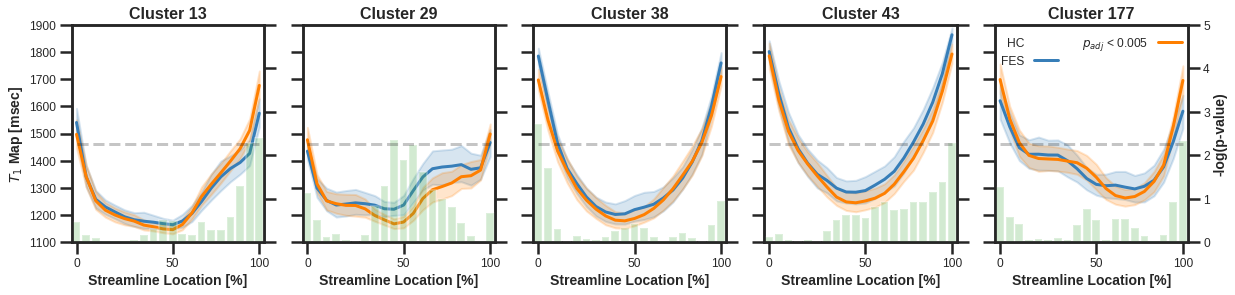

In [96]:
fig, ax = plt.subplots(1,len(sig_T1map_clusters), figsize=(len(sig_T1map_clusters) * 4, 4))

group_T1map_df = handle_df(None, "group_T1map_df", verbose=False)
for ix, cluster in enumerate(sig_T1map_clusters):
    !unzip -qq -u dataframes/T1map.zip dataframes/cluster{cluster}_T1map_df.csv -d .
    
    bundle_T1map_df = handle_df(None, f"cluster{cluster}_T1map_df", verbose=False)
    plot_along_tract(bundle_T1map_df, group_T1map_df, cluster, ax, ix, 
                     ylabel="$T_{1}$ Map [msec]", ylim=[1100, 1900],
                     pval=group_T1map_df[group_T1map_df["Cluster"] == cluster]['alphaFWE'].values[0])

    
    !rm dataframes/*{cluster}_T1map_df.csv
    
fig.savefig(f"{figure_dir}/T1map.svg", dpi=300, bbox_inches="tight")

In [260]:
viz_along_tract('sub-001', 177, group_T1map_df, cci_thresh=15, save=True)

### Clinical Data

* (baseline SOFAS)
* baseline DDD (drug dose)
* baseline PANSS-8 score (total severity)
* duration of untreated illness / psychosis
* baseline dACC GSH and Glutamate~

#### Notes:
* `Group (Diag 4) represent patient group -> 1 - HC; 2 - FEP

In [44]:
handle_session()

Loading notebook session


In [33]:
# Setup dataframe
topsy_clinical_df = pd.read_csv(op.realpath("../TOPSY_clinical.csv"), sep=",")
# topsy_clinical_df = topsy_clinical_df.replace("#NULL!", np.nan)
# topsy_clinical_df["Subject"] = topsy_clinical_df['Subject'].apply(lambda x: 'sub-{0:0>3}'.format(int(x)))
topsy_clinical_df = topsy_clinical_df[topsy_clinical_df["Subject"].isin(topsy_count_df["Subject"].unique())]

### Frontal Lobes
<!-- _31 HC, 53 FES (thresholds: 22, 35 subjects)_ -->
_31 HC, 53 FES (70% threshold: 19 HC, 31 FES subjects)_

In [98]:
# Grab data only from frontal lobes
frontal_lobes_df = cluster_df.copy()
frontal_lobes_df = frontal_lobes_df[frontal_lobes_df["Lobe"].str.contains("1-|6-")]
frontal_lobes_df = frontal_lobes_df[frontal_lobes_df["Count"] >= 5]
temp_df = frontal_lobes_df

frontal_lobes_df["Survive threshold"] = 0
for cluster in temp_df["Cluster"].unique().tolist():
    if (
        len(temp_df[(temp_df["Cluster"] == cluster) & (temp_df["Group"] == 0)]) >= 19
        and len(temp_df[(temp_df["Cluster"] == cluster) & (temp_df["Group"] == 1)])
        >= 31
    ):
        idx = frontal_lobes_df[frontal_lobes_df["Cluster"] == cluster].index
        frontal_lobes_df.loc[idx, "Survive threshold"] = 1

del temp_df

#### Cluster Presence

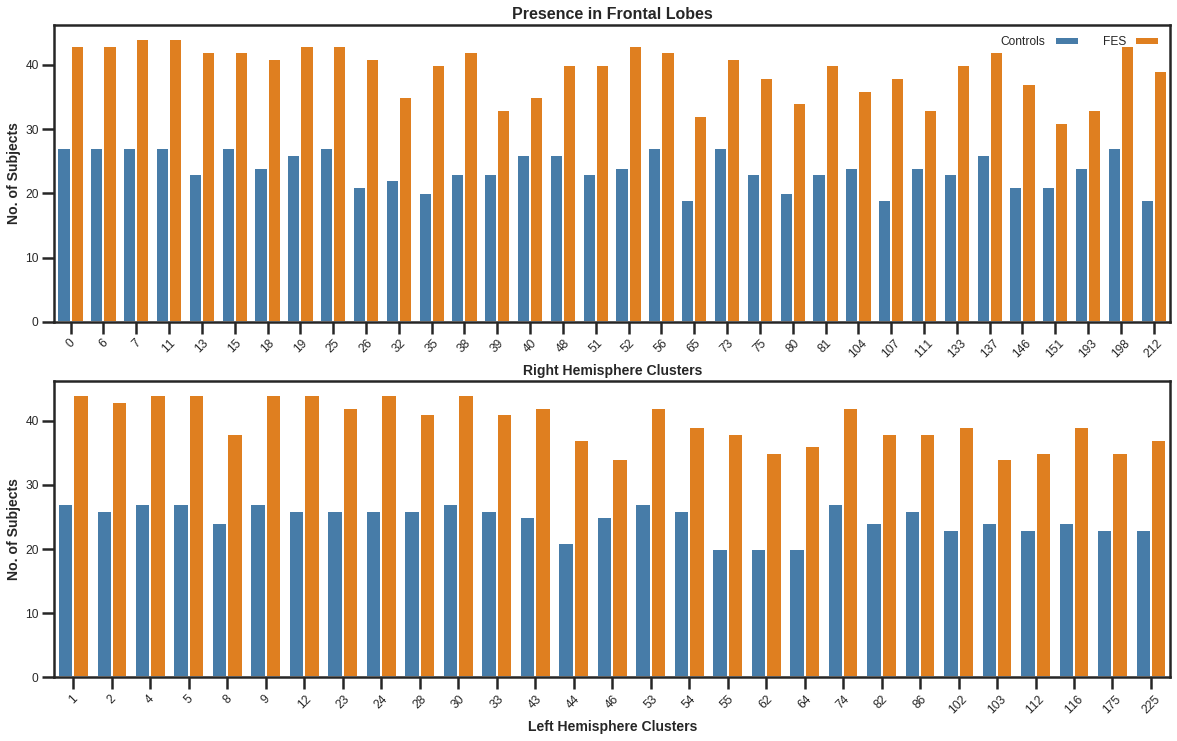

In [99]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12))

# Determine number of subjects for each cluster, irrespective of thresholds
for idx, lobe in enumerate(["1-", "6-"]):
    sns.countplot(
        x="Cluster",
        data=frontal_lobes_df[
            (frontal_lobes_df["Present"] == 1) 
            & (frontal_lobes_df["Survive threshold"] == 1)
            & (frontal_lobes_df["Lobe"].str.contains(lobe))
        ],
        hue="Group",
        ax=ax[idx],
    )

    ax[idx].set_ylabel("No. of Subjects")
    ax[idx].tick_params(axis="x", labelrotation=45)

    if idx == 0:
        ax[idx].set_xlabel("Right Hemisphere Clusters")
        ax[idx].set_title("Presence in Frontal Lobes")
        handles, labels = ax[idx].get_legend_handles_labels()
        ax[idx].legend(
            handles[:2],
            ["Controls", "FES"],
            frameon=False,
            markerfirst=False,
            ncol=2,
            loc="upper right",
        )
    else:
        ax[idx].set_xlabel("Left Hemisphere Clusters")
        ax[idx].get_legend().remove()

plt.show()
plt.close()

#### Streamline counts

In [100]:
# Get streamline counts
for subject in tqdm(frontal_lobes_df["Subject"].unique()):
    grp = frontal_lobes_df[(frontal_lobes_df["Subject"] == subject)]["Group"].values[0]
    sl_count = frontal_lobes_df[(frontal_lobes_df["Subject"] == subject) &
                                (frontal_lobes_df["Survive threshold"] == 1)]['Count'].sum()
    
    frontal_lobes_df = frontal_lobes_df.append({'Subject': subject,
                                                'Group': grp,
                                                'Cluster': "Total",
                                                'Count': sl_count,
                                                'Lobe': np.nan,
                                                'Present': np.nan,
                                                'Survive threshold': np.nan
                                               }, ignore_index=True)


hc_count = frontal_lobes_df[(frontal_lobes_df["Group"] == 0) & (frontal_lobes_df["Cluster"] == "Total")]['Count'].to_list()
fes_count = frontal_lobes_df[(frontal_lobes_df["Group"] == 1) & (frontal_lobes_df["Cluster"] == "Total")]['Count'].to_list()

# Test for normality
print(scipy.stats.shapiro(hc_count))
print(scipy.stats.shapiro(fes_count))

# Tests if two samples have equal variances
print(scipy.stats.levene(hc_count, fes_count))

100%|█████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 165.23it/s]

(0.9706078171730042, 0.6179438829421997)
(0.964655339717865, 0.19384239614009857)
LeveneResult(statistic=0.0031951387899156296, pvalue=0.9550865020563545)


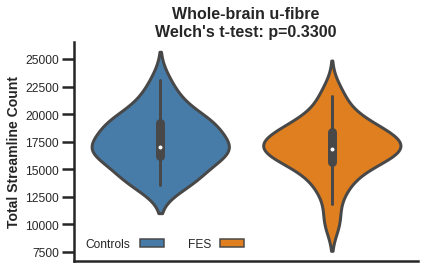

In [102]:
# Frontal lobe streamline count - HC v P
%matplotlib inline

plot_df = frontal_lobes_df[frontal_lobes_df["Cluster"] == "Total"]

# gridkw = dict(height_ratios=[.6, .4], hspace=0.1)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

sns.violinplot(
    x="Group", y="Count", data=plot_df, hue="Group", dodge=False, inner="box", ax=ax
)

# Plot settings
sns.despine(ax=ax, right=True, top=True)
ax.set_xticks([])
ax.set_xticklabels([])
ax.get_legend().remove()
ax.set_xlabel("")
ax.set_ylabel("Total Streamline Count")

# Headings
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[:2],
    ["Controls", "FES"],
    frameon=False,
    markerfirst=False,
    ncol=2,
    loc="lower left",
)

# Non parametric t test
stat, p = scipy.stats.ttest_ind(
    plot_df[plot_df["Group"] == 0]["Count"].tolist(),
    plot_df[plot_df["Group"] == 1]["Count"].tolist(),
    equal_var=False,
)
ax.set_title(f"Whole-brain u-fibre\nWelch's t-test: p={p:.4f}")

fig.tight_layout()
filename = "{0}/1_TotalStreamlineCount_HCvFES.svg".format(figure_dir)
# plt.savefig(filename, dpi=300, bbox_inches="tight", facecolor="white")
plt.show()
plt.close()

del plot_df

100%|██████████████████████████████████████████| 29/29 [00:00<00:00, 622.74it/s]


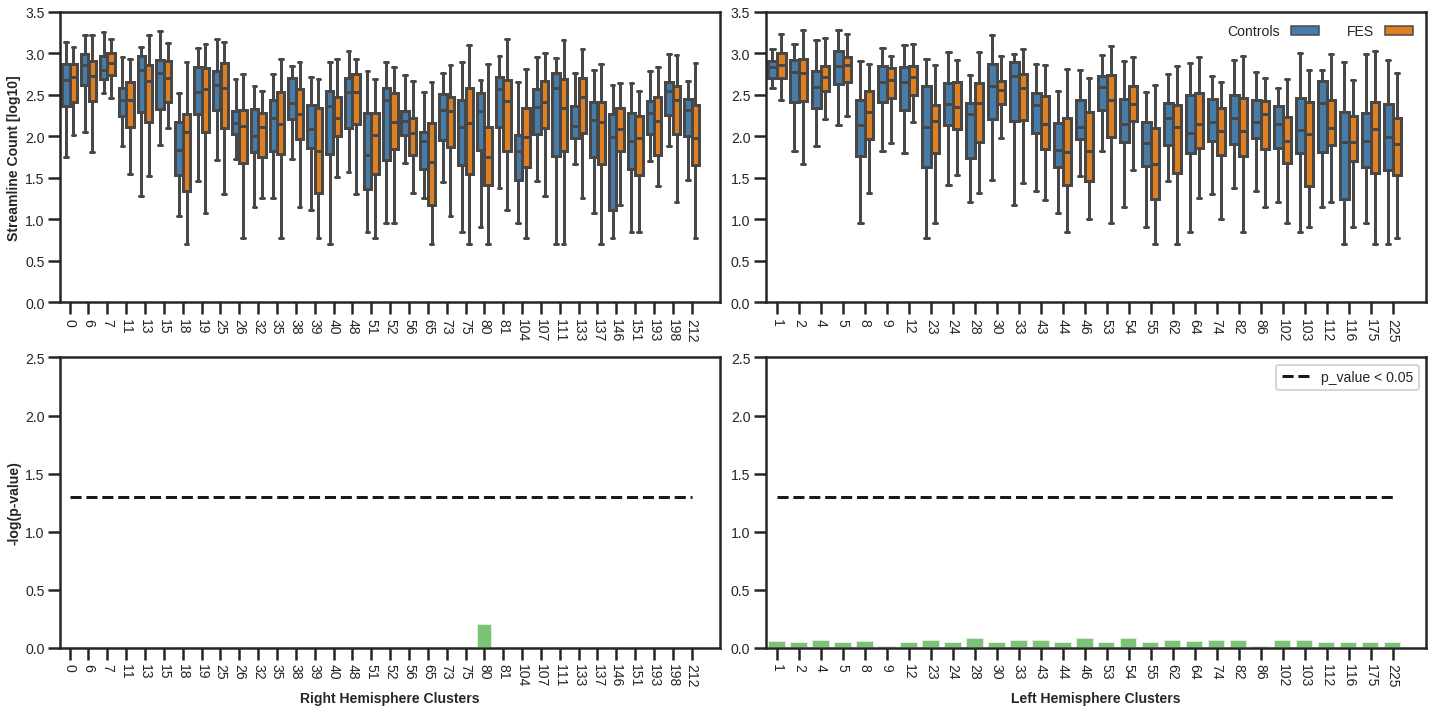

In [21]:
# Bundle specific streamline count
%matplotlib inline

fig, ax = plt.subplots(2, 2, figsize=(20, 10))

# Drop rows/columns of non analyzed subjects and clusters
for lobe_idx, lobe in enumerate(["1-", "6-"]):
    plot_df = frontal_lobes_df[
        (frontal_lobes_df["Survive threshold"] == 1) &
        (frontal_lobes_df["Lobe"].str.contains(lobe))
    ].sort_values("Cluster")

    for cluster in np.unique(plot_df["Cluster"].values):
        plot_df["Count (log10)"] = np.log10(plot_df["Count"])
        plot_df = plot_df.replace(-np.inf, 0)

    # Density plot
    sns.boxplot(
        x="Cluster",
        y="Count (log10)",
        data=plot_df,
        hue="Group",
        ax=ax[0][lobe_idx],
        fliersize=0,
        dodge=True,
    )

    # Settings
    ax[0][lobe_idx].set_ylim([0, 3.5])
    ax[0][lobe_idx].tick_params("x", labelrotation=-90)
    ax[0][lobe_idx].set_xlim([-0.5, len(np.unique(plot_df["Cluster"])) + 0.5])
    ax[0][lobe_idx].set_xlabel("")
    ax[0][lobe_idx].set_title("")

    if lobe_idx == 0:
        ax[0][lobe_idx].set_ylabel("Streamline Count [log10]")
        ax[0][lobe_idx].get_legend().remove()
    else:
        ax[0][lobe_idx].set_ylabel("")
        handles, labels = ax[0][lobe_idx].get_legend_handles_labels()
        ax[0][lobe_idx].legend(
            handles[:2],
            ["Controls", "FES"],
            frameon=False,
            markerfirst=False,
            ncol=2,
            loc="upper right",
        )

    # Comute differences between groups
    p_list = np.array([])
    for cidx in tqdm(np.unique(plot_df["Cluster"].values)):
        stat, p = scipy.stats.ttest_ind(
            plot_df[(plot_df["Group"] == 0) & (plot_df["Cluster"] == cidx)][
                "Count"
            ].tolist(),
            plot_df[(plot_df["Group"] == 1) & (plot_df["Cluster"] == cidx)][
                "Count"
            ].tolist(),
            equal_var=False,
        )
        p_list = np.append(p_list, p)

    nan_idx = np.argwhere(np.isnan(p_list))
    p_list = np.delete(p_list, nan_idx)
    _, cor_plist, _, _ = smstats.multipletests(p_list, method="fdr_bh")
    for idx in nan_idx:
        cor_plist = np.insert(cor_plist, idx, np.nan)

    # p-value plot
    # Shows p-value for significance following FDR correction (BH)
    (l1,) = ax[1][lobe_idx].plot(
        np.arange(len(cor_plist)),
        np.ones((len(cor_plist), 1)) * (-np.log10(0.05)),
        "k--",
        label="p_value < 0.05",
    )

    ax[1][lobe_idx].bar(
        np.arange(len(cor_plist)),
        -np.log10(cor_plist),
        color=cb_color_cycle[2],
        width=0.8,
        alpha=0.75,
    )

    # Settings
    ax[1][lobe_idx].set_ylim([0, 2.5])
    ax[1][lobe_idx].set_xticks(np.arange(len(cor_plist)))
    ax[1][lobe_idx].set_xticklabels(plot_df["Cluster"].unique().tolist())
    ax[1][lobe_idx].set_xlim([-0.5, len(cor_plist) + 0.5])
    ax[1][lobe_idx].tick_params("x", labelrotation=-90)

    if lobe_idx == 0:
        ax[1][lobe_idx].set_ylabel("-log(p-value)")
        ax[1][lobe_idx].set_xlabel("Right Hemisphere Clusters")
    else:
        ax[1][lobe_idx].set_ylabel("")
        ax[1][lobe_idx].set_xlabel("Left Hemisphere Clusters")
        ax[1][lobe_idx].legend(handles=[l1], loc="upper right")


fig.tight_layout()
filename = f"{figure_dir}/3_FrontalLobesStreamlineCount_HCvFES_NonThreshold.svg"
# plt.savefig(filename, dpi=300, bbox_inches="tight", facecolor="white")
plt.show()
plt.close()

del plot_df

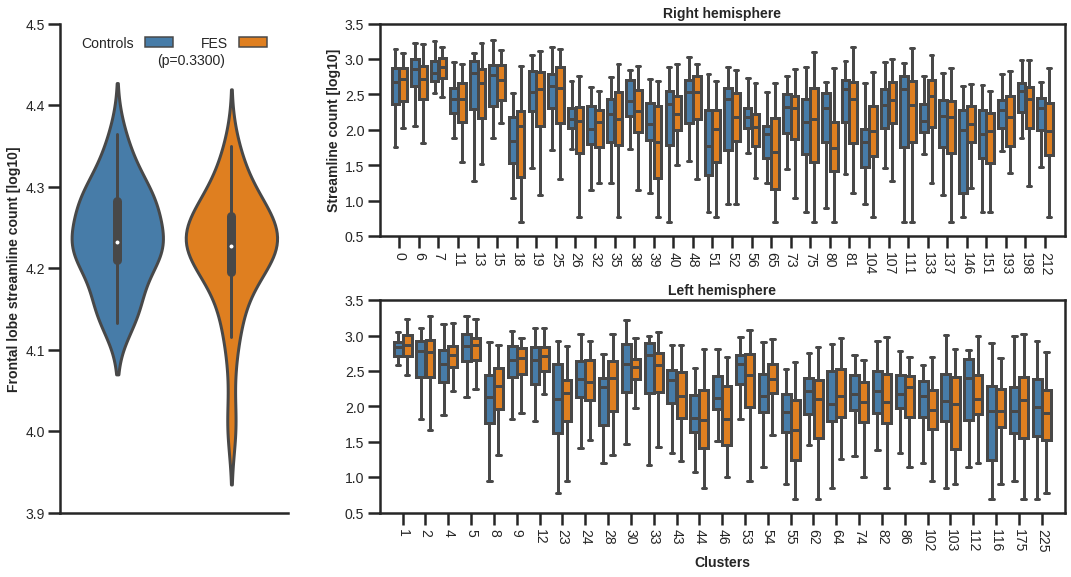

In [22]:
%matplotlib inline 

import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(18, 9))

fontsize = 14
boxsize = 3 

# Main gridspec (2 columns)
gs_parent = gridspec.GridSpec(1,2,
                              figure=fig,
                              width_ratios=[.25, .75])

# Sub gridspec (left column)
gs_left = gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec=gs_parent[0])
ax_left = fig.add_subplot(gs_left[0])

# Plotting
plot_df = frontal_lobes_df[frontal_lobes_df["Cluster"] == "Total"]
plot_df["Count [log10]"] = np.log10(plot_df['Count'])
sns.violinplot(
    x="Group", y="Count [log10]", data=plot_df, hue="Group", dodge=False, inner="box", ax=ax_left
)

# Plot settings
sns.despine(ax=ax_left, right=True, top=True)
ax_left.set_xticks([])
ax_left.set_xticklabels([])
ax_left.get_legend().remove()
ax_left.set_xlabel("")
ax_left.set_ylabel("Frontal lobe streamline count [log10]", fontsize=fontsize)
ax_left.set_ylim([3.9, 4.5])

# Non parametric t test
stat, p = scipy.stats.ttest_ind(
    plot_df[plot_df["Group"] == 0]["Count"].tolist(),
    plot_df[plot_df["Group"] == 1]["Count"].tolist(),
    equal_var=False,
)
ax_left.text(0.35, 4.45, f"(p={p:.4f})", fontsize=fontsize)

# Headings
handles, labels = ax_left.get_legend_handles_labels()
ax_left.legend(
    handles[:2],
    ["Controls", "FES"],
    frameon=False,
    markerfirst=False,
    ncol=2,
    loc="upper center",
    fontsize=fontsize
)


# Sub gridspec (right column)
gs_right = gridspec.GridSpecFromSubplotSpec(2,1,
                                            subplot_spec=gs_parent[1],
                                            hspace=0.3)
ax_right_top = fig.add_subplot(gs_right[0])
ax_right_bot = fig.add_subplot(gs_right[1])

# Plotting right hemi
plot_df = frontal_lobes_df[
    (frontal_lobes_df["Survive threshold"] == 1) &
    (frontal_lobes_df["Lobe"].str.contains("1-"))
].sort_values("Cluster")
plot_df["Count [log10]"] = np.log10(plot_df["Count"])
        
sns.boxplot(
    x="Cluster",
    y="Count [log10]",
    data=plot_df,
    hue="Group",
    ax=ax_right_top,
    fliersize=0,
    dodge=True,
)

# Settings
ax_right_top.set_ylim([.5, 3.5])
ax_right_top.tick_params("x", labelrotation=-90)
ax_right_top.set_xlim([-1, len(np.unique(plot_df["Cluster"]))])
ax_right_top.set_xlabel("")
ax_right_top.set_ylabel("Streamline count [log10]", fontsize=fontsize)
ax_right_top.set_title('Right hemisphere', fontsize=fontsize)
ax_right_top.get_legend().remove()


# Plotting left hemi
plot_df = frontal_lobes_df[
    (frontal_lobes_df["Survive threshold"] == 1) &
    (frontal_lobes_df["Lobe"].str.contains("6-"))
].sort_values("Cluster")
plot_df["Count [log10]"] = np.log10(plot_df["Count"])
        
sns.boxplot(
    x="Cluster",
    y="Count [log10]",
    data=plot_df,
    hue="Group",
    ax=ax_right_bot,
    fliersize=0,
    dodge=True,
)

# Settings
ax_right_bot.set_ylim([.5, 3.5])
ax_right_bot.tick_params("x", labelrotation=-90)
ax_right_bot.set_xlim([-1, len(np.unique(plot_df["Cluster"]))])
ax_right_bot.set_xlabel("Clusters", fontsize=fontsize)
ax_right_bot.set_ylabel("")
ax_right_bot.set_title('Left hemisphere', fontsize=fontsize)
ax_right_bot.get_legend().remove()

plt.savefig(f"{figure_dir}/fig2.svg", dpi=300, bbox_inches="tight", facecolor="white")

plt.show()
plt.close()

#### Along tract scalars

##### FA

In [105]:
template_centroids_df = handle_df(None, "template_centroids_df")

print("Unzipping subject csvs...")
os.system("unzip -u dataframes/fa.zip -d .")

subject_mean_df = dict()
subject_mean_df["Subject"] = []
subject_mean_df["Group"] = []
subject_mean_df["Cluster"] = []
subject_mean_df["Lobe"] = []

for i in np.arange(20):
    subject_mean_df[f"Sample {i}"] = []

for lobe_idx, lobe in enumerate(["1-", "6-"]):
    temp_df = frontal_lobes_df[(frontal_lobes_df["Lobe"].str.contains(lobe)) & 
                               (frontal_lobes_df["Survive threshold"] == 1)].dropna()
    temp_df = temp_df[(temp_df["Lobe"].str.contains(lobe))]

    for cluster in temp_df["Cluster"].unique():
        bundle_fa_df = handle_df(None, f"cluster{cluster}_fa_df")

        for i in range(20):
            df = (
                bundle_fa_df[bundle_fa_df["Streamline Sample"] == i]
                .groupby(["Subject"])
                .mean()
            )
            subject_mean_df[f"Sample {i}"].extend(df["Scalar"].tolist())
            
        subject_mean_df["Subject"].extend(df.index.tolist())
        subject_mean_df["Group"].extend(demo_df[demo_df["Subject"].isin(bundle_fa_df["Subject"].unique())]["Group"].tolist())
        subject_mean_df["Cluster"].extend([cluster] * len(df.index.tolist()))
        subject_mean_df["Lobe"].extend(
            temp_df[temp_df["Cluster"] == cluster]["Lobe"].unique().tolist()
            * len(df.index.tolist())
        )

        clear_output(wait=True)

subject_fa_df = pd.DataFrame(subject_mean_df)
subject_fa_df['Group'] = subject_fa_df['Group'].map({"HC": 0, "P": 1})

print("Cleaning up directory...")
os.system("rm dataframes/cluster*_fa_df.csv")

handle_df(subject_fa_df, "subject_fa_frontal_df", save=True)

Cleaning up directory...
Saving dataframe


In [106]:
# Create a general confounds dataframe
subject_fa_df["Group"] = subject_fa_df["Group"].astype(int)
subject_fa_df = subject_fa_df.dropna()
subject_confounds_df = subject_fa_df.copy()

for i in np.arange(20):
    subject_confounds_df = subject_confounds_df.drop(columns=f"Sample {i}")

for idx in subject_confounds_df.index.tolist():
    subj = subject_confounds_df.loc[idx, "Subject"]
    subject_confounds_df.at[idx, "Age"] = int(
        demo_df[demo_df["Subject"] == subj]["Age"].values[0]
    )
    subject_confounds_df.at[idx, "Sex"] = demo_df[
        demo_df["Subject"] == subj
    ]["Sex"].values[0]

subject_confounds_df = subject_confounds_df.replace("M", int(0))
subject_confounds_df = subject_confounds_df.replace("F", int(1))

In [107]:
group_df = dict()
group_df["Cluster"] = []
group_df["Lobe"] = []
group_df["Scalar"] = []
group_df["Streamline Sample"] = []
group_df["t-stat"] = []
group_df["p-val"] = []
group_df["alphaFWE"] = []

# Correct for confounds
print("Correcting for confounds...")
corrected_samples = unconfound(
    subject_fa_df.drop(columns=["Subject", "Group", "Cluster", "Lobe"]).to_numpy(),
    subject_confounds_df.drop(columns=["Subject", "Cluster", "Lobe"]).to_numpy(),
    group_data=True,
)
for idx, df_idx in enumerate(subject_fa_df.index.tolist()):
    for sample in np.arange(corrected_samples.shape[1]):
        subject_fa_df.at[df_idx, f"Sample {sample}"] = corrected_samples[idx, sample]

# Permutation-based multiple comparison correction
print("Adjusting p-value for multiple comparisons...")
alphaFWE, _, _, _, = AFQ_MultiCompCorrection(
    subject_fa_df.drop(columns=["Group", "Cluster", "Subject", "Lobe"]).to_numpy(),
    y=subject_fa_df["Group"].astype("int").tolist(),
    nperm=10000,
)

# T-test
print("Testing for group differences...")
for cluster in tqdm(np.unique(subject_fa_df["Cluster"].tolist()), position=0):
    df = subject_fa_df[subject_fa_df["Cluster"] == cluster]

    for i in tqdm(np.arange(20)):

        t, p = scipy.stats.ttest_ind(
            df[(df["Group"] == 0)][f"Sample {i}"].values,
            df[(df["Group"] == 1)][f"Sample {i}"].values,
            equal_var=False,
        )

        group_df["Cluster"].append(cluster)
        group_df["Lobe"].append(df["Lobe"].unique()[0])
        group_df["t-stat"].append(t)
        group_df["p-val"].append(p)
        group_df["Streamline Sample"].append(i)
        group_df["Scalar"].append("FA")
        group_df["alphaFWE"].append(alphaFWE)

    clear_output(wait=True)

group_fa_df = pd.DataFrame(group_df)

handle_df(group_fa_df, "group_fa_frontal_df", save=True)
handle_session(save=True)

100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 34.96it/s]


Saving dataframe
Saving notebook session


In [108]:
group_fa_df = handle_df(None, "group_fa_frontal_df", verbose=False)
sig_fa_clusters = np.unique(
    group_fa_df[group_fa_df["p-val"] < group_fa_df["alphaFWE"]]["Cluster"]
)

for cluster in sig_fa_clusters:          
    sig_cluster_summary(cluster, topsy_count_df, sl_min=5)

Cluster 9 summary:
Connectivity: L Frontal - L Frontal
No. of controls: 27
Avg. streamline count: 475.4 [(6.0, 1155.0)]
No. of FES: 44
Avg. streamline count: 471.7 [(15.0, 930.0)]

Cluster 46 summary:
Connectivity: L Frontal - L Frontal
No. of controls: 25
Avg. streamline count: 191.9 [(8.0, 636.0)]
No. of FES: 34
Avg. streamline count: 123.7 [(10.0, 505.0)]

Cluster 65 summary:
Connectivity: R Frontal - R Frontal
No. of controls: 19
Avg. streamline count: 103.2 [(5.0, 342.0)]
No. of FES: 32
Avg. streamline count: 96.5 [(5.0, 453.0)]



##### RD

In [109]:
template_centroids_df = handle_df(None, "template_centroids_df")

print("Unzipping subject csvs...")
os.system("unzip -u dataframes/rd.zip -d .")

subject_mean_df = dict()
subject_mean_df["Subject"] = []
subject_mean_df["Group"] = []
subject_mean_df["Cluster"] = []
subject_mean_df["Lobe"] = []

for i in np.arange(20):
    subject_mean_df[f"Sample {i}"] = []

for lobe_idx, lobe in enumerate(["1-", "6-"]):
    temp_df = frontal_lobes_df[(frontal_lobes_df["Lobe"].str.contains(lobe)) &
                               (frontal_lobes_df["Survive threshold"] == 1)].dropna()
    temp_df = temp_df[(temp_df["Lobe"].str.contains(lobe))]

    for cluster in temp_df["Cluster"].unique():
        bundle_rd_df = handle_df(None, f"cluster{cluster}_rd_df")

        for i in range(20):
            df = (
                bundle_rd_df[bundle_rd_df["Streamline Sample"] == i]
                .groupby(["Subject"])
                .mean()
            )
            subject_mean_df[f"Sample {i}"].extend(df["Scalar"].tolist())

        subject_mean_df["Subject"].extend(df.index.tolist())
        subject_mean_df["Group"].extend(demo_df[demo_df["Subject"].isin(bundle_rd_df["Subject"].unique())]["Group"].tolist())
        subject_mean_df["Cluster"].extend([cluster] * len(df.index.tolist()))
        subject_mean_df["Lobe"].extend(
            temp_df[temp_df["Cluster"] == cluster]["Lobe"].unique().tolist()
            * len(df.index.tolist())
        )

        clear_output(wait=True)

subject_rd_df = pd.DataFrame(subject_mean_df)
subject_rd_df['Group'] = subject_rd_df['Group'].map({"HC": 0, "P": 1})

print("Cleaning up directory...")
os.system("rm dataframes/cluster*_rd_df.csv")

handle_df(subject_rd_df, "subject_rd_frontal_df", save=True)

Cleaning up directory...
Saving dataframe


In [110]:
group_df = dict()
group_df["Cluster"] = []
group_df["Lobe"] = []
group_df["Scalar"] = []
group_df["Streamline Sample"] = []
group_df["t-stat"] = []
group_df["p-val"] = []
group_df["alphaFWE"] = []

# Correct for confounds
print("Correcting for confounds...")
corrected_samples = unconfound(
    subject_rd_df.drop(columns=["Subject", "Group", "Cluster", "Lobe"]).to_numpy(),
    subject_confounds_df.drop(columns=["Subject", "Cluster", "Lobe"]).to_numpy(),
    group_data=True,
)
for idx, df_idx in enumerate(subject_rd_df.index.tolist()):
    for sample in np.arange(corrected_samples.shape[1]):
        subject_rd_df.at[df_idx, f"Sample {sample}"] = corrected_samples[idx, sample]

# Permutation-based multiple comparison correction
print("Adjusting p-value for multiple comparisons...")
alphaFWE, _, _, _, = AFQ_MultiCompCorrection(
    subject_rd_df.drop(columns=["Group", "Cluster", "Subject", "Lobe"]).to_numpy(),
    y=subject_rd_df["Group"].astype("int").tolist(),
    nperm=10000,
)

# T-test
print("Testing for group differences...")
for cluster in tqdm(np.unique(subject_rd_df["Cluster"].tolist()), position=0):
    df = subject_rd_df[subject_rd_df["Cluster"] == cluster]

    for i in tqdm(np.arange(20)):

        t, p = scipy.stats.ttest_ind(
            df[(df["Group"] == 0)][f"Sample {i}"].values,
            df[(df["Group"] == 1)][f"Sample {i}"].values,
            equal_var=False,
        )

        group_df["Cluster"].append(cluster)
        group_df["Lobe"].append(df["Lobe"].unique()[0])
        group_df["t-stat"].append(t)
        group_df["p-val"].append(p)
        group_df["Streamline Sample"].append(i)
        group_df["Scalar"].append("RD")
        group_df["alphaFWE"].append(alphaFWE)

    clear_output(wait=True)

group_rd_df = pd.DataFrame(group_df)

handle_df(group_rd_df, "group_rd_frontal_df", save=True)
handle_session(save=True)

100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 35.22it/s]


Saving dataframe
Saving notebook session


##### AD

In [111]:
template_centroids_df = handle_df(None, "template_centroids_df")

print("Unzipping subject csvs...")
os.system("unzip -u dataframes/ad.zip -d .")

subject_mean_df = dict()
subject_mean_df["Subject"] = []
subject_mean_df["Group"] = []
subject_mean_df["Cluster"] = []
subject_mean_df["Lobe"] = []

for i in np.arange(20):
    subject_mean_df[f"Sample {i}"] = []

for lobe_idx, lobe in enumerate(["1-", "6-"]):
    temp_df = frontal_lobes_df[(frontal_lobes_df["Lobe"].str.contains(lobe)) &
                               (frontal_lobes_df["Survive threshold"] == 1)].dropna()
    temp_df = temp_df[(temp_df["Lobe"].str.contains(lobe))]

    for cluster in temp_df["Cluster"].unique():
        bundle_ad_df = handle_df(None, f"cluster{cluster}_ad_df")

        for i in range(20):
            df = (
                bundle_ad_df[bundle_ad_df["Streamline Sample"] == i]
                .groupby(["Subject"])
                .mean()
            )
            subject_mean_df[f"Sample {i}"].extend(df["Scalar"].tolist())

        subject_mean_df["Subject"].extend(df.index.tolist())
        subject_mean_df["Group"].extend(demo_df[demo_df["Subject"].isin(bundle_ad_df["Subject"].unique())]["Group"].tolist())
        subject_mean_df["Cluster"].extend([cluster] * len(df.index.tolist()))
        subject_mean_df["Lobe"].extend(
            temp_df[temp_df["Cluster"] == cluster]["Lobe"].unique().tolist()
            * len(df.index.tolist())
        )

        clear_output(wait=True)

subject_ad_df = pd.DataFrame(subject_mean_df)
subject_ad_df['Group'] = subject_ad_df['Group'].map({"HC": 0, "P": 1})


print("Cleaning up directory...")
os.system("rm dataframes/cluster*_ad_df.csv")

handle_df(subject_ad_df, "subject_ad_frontal_df", save=True)

Cleaning up directory...
Saving dataframe


In [112]:
group_df = dict()
group_df["Cluster"] = []
group_df["Lobe"] = []
group_df["Scalar"] = []
group_df["Streamline Sample"] = []
group_df["t-stat"] = []
group_df["p-val"] = []
group_df["alphaFWE"] = []

# Correct for confounds
print("Correcting for confounds...")
corrected_samples = unconfound(
    subject_ad_df.drop(columns=["Subject", "Group", "Cluster", "Lobe"]).to_numpy(),
    subject_confounds_df.drop(columns=["Subject", "Cluster", "Lobe"]).to_numpy(),
    group_data=True,
)
for idx, df_idx in enumerate(subject_ad_df.index.tolist()):
    for sample in np.arange(corrected_samples.shape[1]):
        subject_ad_df.at[df_idx, f"Sample {sample}"] = corrected_samples[idx, sample]

# Permutation-based multiple comparison correction
print("Adjusting p-value for multiple comparisons...")
alphaFWE, _, _, _, = AFQ_MultiCompCorrection(
    subject_ad_df.drop(columns=["Group", "Cluster", "Subject", "Lobe"]).to_numpy(),
    y=subject_ad_df["Group"].astype("int").tolist(),
    nperm=10000,
)

# T-test
print("Testing for group differences...")
for cluster in tqdm(np.unique(subject_ad_df["Cluster"].tolist()), position=0):
    df = subject_ad_df[subject_ad_df["Cluster"] == cluster]

    for i in tqdm(np.arange(20)):

        t, p = scipy.stats.ttest_ind(
            df[(df["Group"] == 0)][f"Sample {i}"].values,
            df[(df["Group"] == 1)][f"Sample {i}"].values,
            equal_var=False,
        )

        group_df["Cluster"].append(cluster)
        group_df["Lobe"].append(df["Lobe"].unique()[0])
        group_df["t-stat"].append(t)
        group_df["p-val"].append(p)
        group_df["Streamline Sample"].append(i)
        group_df["Scalar"].append("AD")
        group_df["alphaFWE"].append(alphaFWE)

    clear_output(wait=True)

group_ad_df = pd.DataFrame(group_df)

handle_df(group_ad_df, "group_ad_frontal_df", save=True)
handle_session(save=True)

100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 35.60it/s]


Saving dataframe
Saving notebook session


In [16]:
group_fa_df.head(n=5)

,Cluster,Lobe,Scalar,Streamline Sample,t-stat,p-val,alphaFWE
0,0,1-1,FA,0,2.503944,0.015708,0.004736
1,0,1-1,FA,1,-0.082150,0.934830,0.004736
2,0,1-1,FA,2,-0.238612,0.812361,0.004736
3,0,1-1,FA,3,0.049843,0.960420,0.004736
4,0,1-1,FA,4,0.458096,0.648662,0.004736


##### DTI Figure

100%|█████████████████████████████████████████████| 3/3 [00:12<00:00,  4.06s/it]


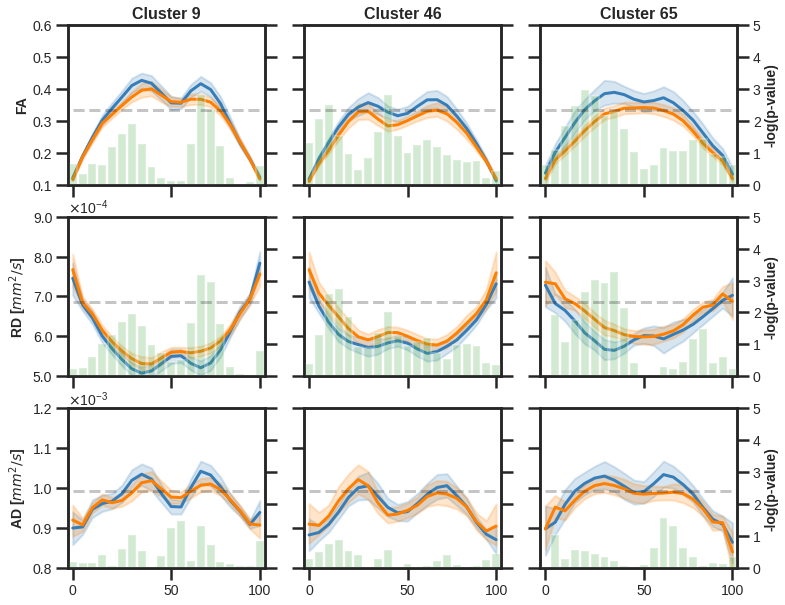

In [28]:
### 3 rows, 3 columns
fig, ax  = plt.subplots(3, 3, figsize=(12, 10))
  
for ix, cluster in enumerate(tqdm(sig_fa_clusters)):
    print("Grabbing csvs of significant clusters...")
    os.system(
        f"unzip -qq -u dataframes/fa.zip dataframes/cluster{cluster}_fa_df.csv -d ."
    )
    os.system(
        f"unzip -qq -u dataframes/rd.zip dataframes/cluster{cluster}_rd_df.csv -d ."
    )
    os.system(
        f"unzip -qq -u dataframes/ad.zip dataframes/cluster{cluster}_ad_df.csv -d ."
    )

    bundle_fa_df = handle_df(None, f"cluster{cluster}_fa_df", verbose=False)
    bundle_rd_df = handle_df(None, f"cluster{cluster}_rd_df", verbose=False)
    bundle_ad_df = handle_df(None, f"cluster{cluster}_ad_df", verbose=False)
    
    label_twinx = True if ix == 2 else False

    plot_along_tract(
        bundle_fa_df,
        group_fa_df,
        cluster,
        ax[0][ix],
        None,
        label_twinx=label_twinx,
        ylabel="FA",
        ylim=[0.1, 0.6],
        pval=group_fa_df[group_fa_df["Cluster"] == cluster]["alphaFWE"].values[0],
    )
    plot_along_tract(
        bundle_rd_df,
        group_rd_df,
        cluster,
        ax[1][ix],
        None,
        sci=True,
        label_twinx=label_twinx,
        ylabel="RD [$mm^2/s$]",
        ylim=[5.0e-4, 9e-4],
        pval=group_rd_df[group_rd_df["Cluster"] == cluster]["alphaFWE"].values[0],
    )
    plot_along_tract(
        bundle_ad_df,
        group_ad_df,
        cluster,
        ax[2][ix],
        None,
        sci=True,
        label_twinx=label_twinx,
        ylabel="AD [$mm^2/s$]",
        ylim=[8e-4, 1.2e-3],
        pval=group_ad_df[group_ad_df["Cluster"] == cluster]["alphaFWE"].values[0],
    )

    # Remove extras from plots
    ax[1][ix].set_title("")
    ax[2][ix].set_title("")
    ax[0][ix].set_xlabel("")
    ax[1][ix].set_xlabel("")
    ax[0][ix].set_xticklabels("")
    ax[1][ix].set_xticklabels("")
    ax[1][ix].get_legend().remove()
    ax[2][ix].get_legend().remove()

    if ix != 6:
        ax[0][ix].get_legend().remove()
        
    if ix != 3:
        ax[2][ix].set_xlabel("")

    if ix != 0:
        ax[0][ix].set_ylabel("")
        ax[1][ix].set_ylabel("")
        ax[2][ix].set_ylabel("")
        ax[0][ix].set_yticklabels("")
        ax[1][ix].set_yticklabels("")
        ax[2][ix].set_yticklabels("")
        
    print("Cleaning up directory...")
    os.system(f"rm dataframes/*{cluster}_fa_df.csv")
    os.system(f"rm dataframes/*{cluster}_rd_df.csv")
    os.system(f"rm dataframes/*{cluster}_ad_df.csv")

    clear_output(wait=False)
    
fig.savefig(f"{figure_dir}/DTI_frontal.svg", dpi=2000, bbox_inches="tight")

plt.show()
plt.close()

In [ ]:
viz_along_tract("sub-001", 9, group_fa_df, cci_thresh=15, save=False)

Caught a Ctrl-C within python, exiting program.


In [257]:
template_centroids_df = handle_df(None, "template_centroids_df")

print("Unzipping subject csvs...")
os.system("unzip -u dataframes/T1map.zip -d .")

subject_mean_df = dict()
subject_mean_df["Subject"] = []
subject_mean_df["Group"] = []
subject_mean_df["Cluster"] = []
subject_mean_df["Lobe"] = []

for i in np.arange(20):
    subject_mean_df[f"Sample {i}"] = []

for lobe_idx, lobe in enumerate(["1-", "6-"]):
    temp_df = frontal_lobes_df[(frontal_lobes_df["Lobe"].str.contains(lobe)) & 
                               (frontal_lobes_df["Survive threshold"] == 1)]

    for cluster in temp_df["Cluster"].unique():
        bundle_T1map_df = handle_df(None, f"cluster{cluster}_T1map_df")

        for i in range(20):
            df = (
                bundle_T1map_df[bundle_T1map_df["Streamline Sample"] == i]
                .groupby(["Subject"])
                .mean()
            )
            subject_mean_df[f"Sample {i}"].extend(df["Scalar"].tolist())

        subject_mean_df["Subject"].extend(df.index.tolist())
        subject_mean_df["Group"].extend(demo_df[demo_df["Subject"].isin(bundle_T1map_df["Subject"].unique())]["Group"].tolist())
        subject_mean_df["Cluster"].extend([cluster] * len(df.index.tolist()))
        subject_mean_df["Lobe"].extend(
            temp_df[temp_df["Cluster"] == cluster]["Lobe"].unique().tolist()
            * len(df.index.tolist())
        )

        clear_output(wait=True)

subject_T1map_df = pd.DataFrame(subject_mean_df)
subject_T1map_df['Group'] = subject_T1map_df['Group'].map({"HC": 0, "P": 1})

print("Cleaning up directory...")
os.system("rm dataframes/cluster*_T1map_df.csv")

handle_df(subject_T1map_df, "subject_T1map_frontal_df", save=True)

Cleaning up directory...
Saving dataframe


In [258]:
# Create a general confounds dataframe
subject_T1map_df["Group"] = subject_T1map_df["Group"].astype(int)
subject_T1map_df = subject_T1map_df.dropna()
subject_confounds_df = subject_T1map_df.copy()

for i in np.arange(20):
    subject_confounds_df = subject_confounds_df.drop(columns=f"Sample {i}")

for idx in subject_confounds_df.index.tolist():
    subj = subject_confounds_df.loc[idx, "Subject"]
    subject_confounds_df.at[idx, "Age"] = int(
        demo_df[demo_df["Subject"] == subj]["Age"].values[0]
    )
    subject_confounds_df.at[idx, "Sex"] = demo_df[
        demo_df["Subject"] == subj
    ]["Sex"].values[0]

subject_confounds_df = subject_confounds_df.replace("M", int(0))
subject_confounds_df = subject_confounds_df.replace("F", int(1))

In [259]:
group_df = dict()
group_df["Cluster"] = []
group_df["Lobe"] = []
group_df["Scalar"] = []
group_df["Streamline Sample"] = []
group_df["t-stat"] = []
group_df["p-val"] = []
group_df["alphaFWE"] = []

# Correct for confounds
print("Correcting for confounds...")
corrected_samples = unconfound(
    subject_T1map_df.drop(columns=["Subject", "Group", "Cluster", "Lobe"]).to_numpy(),
    subject_confounds_df.drop(columns=["Subject", "Cluster", "Lobe"]).to_numpy(),
    group_data=True,
)
for idx, df_idx in enumerate(subject_T1map_df.index.tolist()):
    for sample in np.arange(corrected_samples.shape[1]):
        subject_T1map_df.at[df_idx, f"Sample {sample}"] = corrected_samples[idx, sample]

# Permutation-based multiple comparison correction
print("Adjusting p-value for multiple comparisons...")
alphaFWE, _, _, _, = AFQ_MultiCompCorrection(
    subject_T1map_df.drop(columns=["Group", "Cluster", "Subject", "Lobe"]).to_numpy(),
    y=subject_T1map_df["Group"].astype("int").tolist(),
    nperm=10000,
)

# T-test
print("Testing for group differences...")
for cluster in tqdm(np.unique(subject_T1map_df["Cluster"].tolist()), position=0):
    df = subject_T1map_df[subject_T1map_df["Cluster"] == cluster]

    for i in tqdm(np.arange(20)):

        t, p = scipy.stats.ttest_ind(
            df[(df["Group"] == 0)][f"Sample {i}"].values,
            df[(df["Group"] == 1)][f"Sample {i}"].values,
            equal_var=False,
        )

        group_df["Cluster"].append(cluster)
        group_df["Lobe"].append(df["Lobe"].unique()[0])
        group_df["t-stat"].append(t)
        group_df["p-val"].append(p)
        group_df["Streamline Sample"].append(i)
        group_df["Scalar"].append("T1Map")
        group_df["alphaFWE"].append(alphaFWE)

    clear_output(wait=True)

group_T1map_df = pd.DataFrame(group_df)

handle_df(group_T1map_df, "group_T1map_frontal_df", save=True)
handle_session(save=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 32.77it/s]


Saving dataframe
Saving notebook session


In [260]:
group_T1map_df = handle_df(None, "group_T1map_frontal_df", verbose=False)
sig_T1map_clusters = np.unique(
    group_T1map_df[group_T1map_df["p-val"] < group_T1map_df["alphaFWE"]]["Cluster"]
)

for cluster in sig_T1map_clusters:
    sig_cluster_summary(cluster, topsy_count_df, sl_min=5)

Cluster 13 summary:
Connectivity: R Frontal - R Parietal
No. of controls: 23
Avg. streamline count: 586.0 [(19.0, 1198.0)]
No. of FES: 42
Avg. streamline count: 489.4 [(5.0, 1663.0)]

Cluster 38 summary:
Connectivity: R Frontal - R Frontal
No. of controls: 23
Avg. streamline count: 311.1 [(24.0, 709.0)]
No. of FES: 42
Avg. streamline count: 250.4 [(14.0, 787.0)]

Cluster 43 summary:
Connectivity: L Frontal - L Frontal
No. of controls: 25
Avg. streamline count: 255.2 [(22.0, 744.0)]
No. of FES: 42
Avg. streamline count: 201.7 [(17.0, 725.0)]



Grabbing csvs of significant clusters...
Cleaning up directory...
Grabbing csvs of significant clusters...
Cleaning up directory...
Grabbing csvs of significant clusters...
Cleaning up directory...


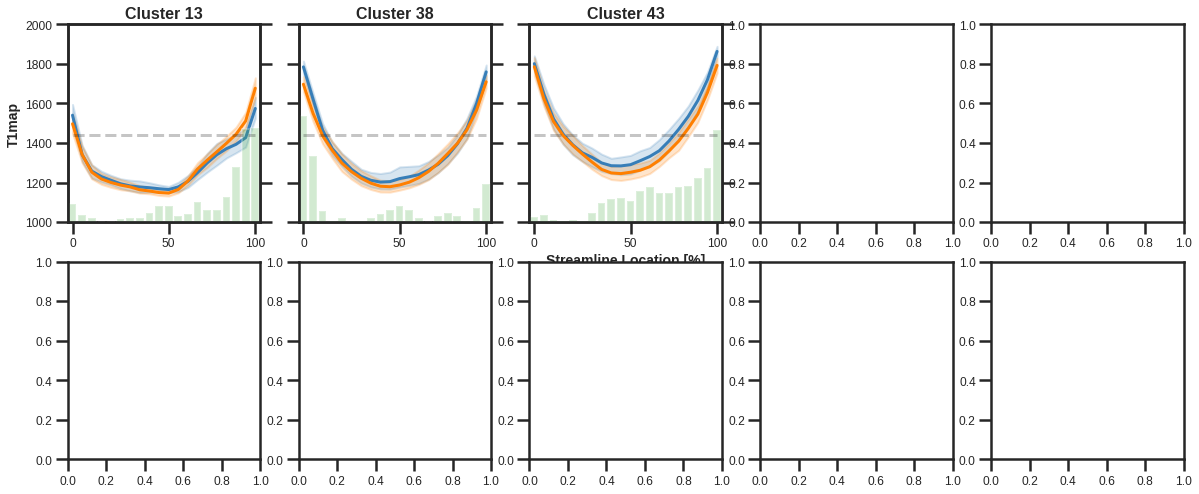

In [261]:
fig, ax = plt.subplots(2, 5, figsize=(20, 8))

group_T1map_df = handle_df(None, "group_T1map_frontal_df", verbose=False)
for ix, cluster in enumerate(sig_T1map_clusters):
    print("Grabbing csvs of significant clusters...")
    os.system(
        f"unzip -qq -u dataframes/T1map.zip dataframes/cluster{cluster}_T1map_df.csv -d ."
    )

    bundle_T1map_df = handle_df(None, f"cluster{cluster}_T1map_df", verbose=False)
    plot_along_tract(
        bundle_T1map_df,
        group_T1map_df,
        cluster,
        ax[ix // 5],
        ix % 5,
        ylabel="T1map",
        ylim=[1000, 2000],
        pval=group_T1map_df[group_T1map_df["Cluster"] == cluster]["alphaFWE"].values[0],
    )

    if ix % 5 != 2:
        ax[ix // 5][ix % 5].set_xlabel("")

    print("Cleaning up directory...")
    os.system(f"rm dataframes/cluster{cluster}_T1map_df.csv")
    
plt.show()
plt.close()

# fig.savefig(f"{figure_dir}/T1map_frontal.svg", dpi=2000, bbox_inches="tight")

In [101]:
viz_along_tract('sub-002', 13, group_T1map_df, cci_thresh=15, save=False)

In [266]:
subject_T1map_df = handle_df(None, "subject_T1map_frontal_df")

subject_T1map_df["Tract Avg"] = subject_T1map_df.drop(
    columns=["Subject", "Group", "Cluster", "Lobe"]
).mean(axis=1)

p_list = []
for cluster in sig_T1map_clusters:
    # for cluster in subject_fa_df["Cluster"].unique().tolist():
    stat, p = scipy.stats.ttest_ind(
        subject_T1map_df[
            (subject_T1map_df["Group"] == 0) & (subject_T1map_df["Cluster"] == cluster)
        ]["Tract Avg"].tolist(),
        subject_T1map_df[
            (subject_T1map_df["Group"] == 1) & (subject_T1map_df["Cluster"] == cluster)
        ]["Tract Avg"].tolist(),
        equal_var=False,
        nan_policy="omit",
    )

    p_list.append(p)

nan_idx = np.argwhere(np.isnan(p_list))
p_list = np.delete(p_list, nan_idx)
_, cor_plist, _, _ = smstats.multipletests(p_list, method="fdr_bh")
for idx in nan_idx:
    cor_plist = np.insert(cor_plist, idx, np.nan)

sig_T1map_idx = np.argwhere(cor_plist < 0.05)
print(
    f"Significant clusters with differences in tract average: {list(sig_T1map_clusters[sig_T1map_idx])}"
)

Loading dataframe...
Significant clusters with differences in tract average: []


#### Clinical Correlations

In [37]:
handle_session()

Loading notebook session


##### Significant portions of tract

In [13]:
import time 

grp = 1
p_uncorr = []
rs = []

for group_df, subject_df in zip([group_fa_df, group_rd_df], ["subject_fa_frontal_df", "subject_rd_frontal_df"]):
    print(subject_df)
    for cidx in sig_fa_clusters:
    # for cidx in [9]: # 9, 46, 65
        print(f"Cluster {cidx}")

        # Find significant indices
        keep_cols = [f"Sample {idx}" for idx in group_df[(group_df["Cluster"] == cidx) & 
                                                         (group_df["p-val"] < group_df["alphaFWE"])]["Streamline Sample"].tolist()]
        keep_cols.extend(["Subject", "Group", "Age", "Cluster", "Lobe"])

        # Merge with clinical df and compute mean from significant portions along-tract
        temp_df = handle_df(None, subject_df, verbose=False)
        temp_df.drop(columns=temp_df.columns.difference(keep_cols), inplace=True)
        temp_df = temp_df[temp_df["Cluster"] == cidx]
        temp_df["Sample Mean"] = temp_df[keep_cols[:-4]].mean(axis=1)

        # Adds back in metabolic information
        temp_df = temp_df.merge(topsy_clinical_df.drop(columns=['Group']), on=["Subject"])
        _, _, r, p, _ = scipy.stats.linregress(temp_df[temp_df["Group"] == grp].dropna()["Sample Mean"], temp_df[temp_df["Group"] == grp].dropna()["PANSS Pos"])
        rs.append(r)
        p_uncorr.append(p)
        print(f"PANSS Pos: r = {r}; p = {p}")

        _, _, r, p, _ = scipy.stats.linregress(temp_df[temp_df["Group"] == grp].dropna()["Sample Mean"], temp_df[temp_df["Group"] == grp].dropna()["PANSS Neg"])
        rs.append(r)
        p_uncorr.append(p)
        print(f"PANSS Neg: r = {r}; p = {p}")

        _, _, r, p, _ = scipy.stats.linregress(temp_df[temp_df["Group"] == grp].dropna()["Sample Mean"], temp_df[temp_df["Group"] == grp].dropna()["PANSS Total"])
        rs.append(r)
        p_uncorr.append(p)
        print(f"PANSS Total: r = {r}; p = {p}")
        
        _, _, r, p, _ = scipy.stats.linregress(temp_df[temp_df["Group"] == grp].dropna()["Sample Mean"], temp_df[temp_df["Group"] == grp].dropna()["SOFAS"])
        rs.append(r)
        p_uncorr.append(p)
        print(f"SOFAS: r = {r}; p = {p}")
        
        _, _, r, p, _ = scipy.stats.linregress(temp_df[temp_df["Group"] == grp].dropna()["Sample Mean"], temp_df[temp_df["Group"] == grp].dropna()["DUP"])
        rs.append(r)
        p_uncorr.append(p)
        print(f"DUP: r = {r}; p = {p}")
        
        _, _, r, p, _ = scipy.stats.linregress(temp_df[temp_df["Group"] == grp].dropna()["Sample Mean"], temp_df[temp_df["Group"] == grp].dropna()["Age"])
        rs.append(r)
        p_uncorr.append(p)
        print(f"Age: r = {r}; p = {p}")
        
        # time.sleep(3)
        # input("Press enter to continue...")
        # clear_output(wait=True)
        
        print("\n\n")

p_cor = smstats.multipletests(p_uncorr, method="fdr_bh")[1]
print(np.argwhere(p_cor < 0.05))
print(p_cor)
# print(f"\nCorrected p-values (sorted): {p_cor}")

subject_fa_frontal_df
Cluster 9
PANSS Pos: r = -0.31569037827176205; p = 0.1633044845471232
PANSS Neg: r = -0.17312003499460163; p = 0.45298284666873445
PANSS Total: r = -0.3762900572107043; p = 0.092717423723559
SOFAS: r = 0.3043843751238123; p = 0.1797432317769455
DUP: r = 0.1852144046524685; p = 0.4215255986630938
Age: r = 0.2343299637243678; p = 0.30658884344664666



Cluster 46
PANSS Pos: r = -0.24706754233636288; p = 0.33905853710652556
PANSS Neg: r = 0.26623284998143354; p = 0.30165631131532894
PANSS Total: r = -0.11309979823308211; p = 0.6656003361125733
SOFAS: r = 0.05584204759872409; p = 0.8314281526668319
DUP: r = -0.2581026276496121; p = 0.31721015452300744
Age: r = 0.15132937015323755; p = 0.562065159231052



Cluster 65
PANSS Pos: r = 0.11008914972441738; p = 0.6636616815489667
PANSS Neg: r = -0.1570901109858236; p = 0.5336038663287777
PANSS Total: r = 0.004999715346135209; p = 0.9842913614343992
SOFAS: r = -0.2760413228482862; p = 0.26752297698916294
DUP: r = 0.081136724

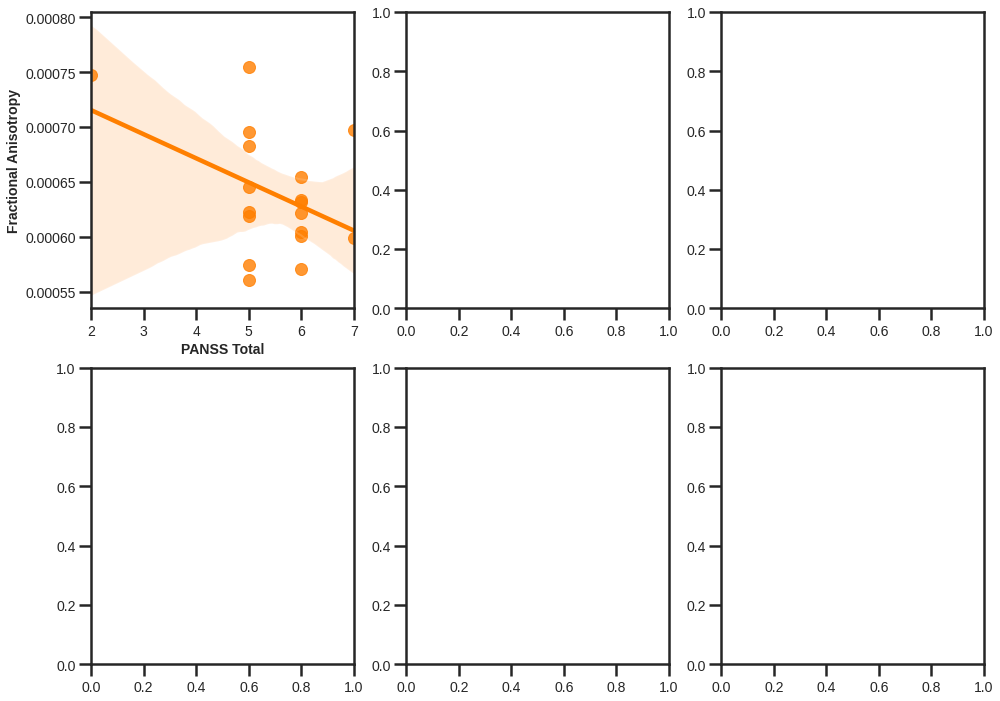

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 3, figsize=(16,12))

# Currently dropping subjects without missing clinical data
# sns.regplot(y="Sample Mean", x="PANSS Total", data=temp_df[temp_df["Group"] == 0].dropna(), color=cb_color_cycle[0], ax=ax1[0])
sns.regplot(y="Sample Mean", x="CGI-S", data=temp_df[temp_df["Group"] == 1].dropna(), color=cb_color_cycle[1], ax=ax1[0])
ax1[0].set_xlabel("PANSS Total")
ax1[0].set_ylabel("Fractional Anisotropy")

# sns.regplot(y="Sample Mean", x="PANSS Neg", data=temp_df[temp_df["Group"] == 0].dropna(), color=cb_color_cycle[0], ax=ax1[1])
# sns.regplot(y="Sample Mean", x="PANSS Neg", data=temp_df[temp_df["Group"] == 1].dropna(), color=cb_color_cycle[1], ax=ax1[1])
# ax1[1].set_xlabel("PANSS Negative")
# ax1[1].set_ylabel("")
# ax1[1].set_title(f"Cluster {cidx}")

# sns.regplot(y="Sample Mean", x="PANSS Total", data=temp_df[temp_df["Group"] == 0].dropna(), color=cb_color_cycle[0], ax=ax1[2])
# sns.regplot(y="Sample Mean", x="PANSS Total", data=temp_df[temp_df["Group"] == 1].dropna(), color=cb_color_cycle[1], ax=ax1[2])
# ax1[2].set_xlabel("PANSS Total")
# ax1[2].set_ylabel("")

# sns.regplot(y="Sample Mean", x="Glutamate (Glu)", data=temp_df[temp_df["Group"] == 0].dropna(), color=cb_color_cycle[0], ax=ax2[0])
# sns.regplot(y="Sample Mean", x="Glutamate (Glu)", data=temp_df[temp_df["Group"] == 1].dropna(), color=cb_color_cycle[1], ax=ax2[0])
# ax2[0].set_xlabel("Glutamate Concentration")
# ax2[0].set_ylabel("Fractional Anisotropy")

# sns.regplot(y="Sample Mean", x="Glutathione", data=temp_df[temp_df["Group"] == 0].dropna(), color=cb_color_cycle[0], ax=ax2[1])
# sns.regplot(y="Sample Mean", x="Glutathione", data=temp_df[temp_df["Group"] == 1].dropna(), color=cb_color_cycle[1], ax=ax2[1])
# ax2[1].set_xlabel("Gluthatione Concentration")
# ax2[1].set_ylabel("")

# sns.regplot(y="Sample Mean", x="NAA", data=temp_df[temp_df["Group"] == 0].dropna(), color=cb_color_cycle[0], ax=ax2[2])
# sns.regplot(y="Sample Mean", x="NAA", data=temp_df[temp_df["Group"] == 1].dropna(), color=cb_color_cycle[1], ax=ax2[2])
# ax2[2].set_xlabel("NAA Concentration")
# ax2[2].set_ylabel("")

plt.show()
plt.close()

In [15]:
grp = 'FES'
var = 'Age'

# By Sex
topsy_clinical_df[topsy_clinical_df['Group Detailed']==grp].groupby('Sex').describe()[var].transpose()

# All together (var not used)
topsy_clinical_df[topsy_clinical_df['Group Detailed']==grp].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,44.0,23.227273,4.589491,16.00,19.7500,23.000,25.500,39.0
DDD,23.0,2.089565,3.227291,0.00,0.0000,1.500,2.500,15.0
DUP,30.0,8.750000,15.328901,0.25,1.0625,2.875,9.125,78.0
PANSS Pos,44.0,12.272727,3.412451,1.00,10.0000,12.000,14.000,20.0
PANSS Neg,44.0,7.681818,4.408094,0.00,3.0000,7.500,11.000,17.0
PANSS Total,43.0,25.930233,7.129400,15.00,20.5000,25.000,29.000,49.0
SOFAS,44.0,38.772727,12.441236,15.00,30.0000,36.000,44.250,70.0
CGI-S,43.0,5.232558,1.042826,2.00,5.0000,5.000,6.000,7.0


In [291]:
handle_session(save=True)

Saving notebook session
